In [9]:
using Pkg
Pkg.instantiate()

In [10]:
using Revise, CairoMakie
using ColonyImages
using DataFrames, CSV, FileIO, Dates, Serialization, Chain, DataFramesMeta
using Statistics
import ColorSchemes as co 

In [11]:
image_data = "data//metrics"
for (i,x) in enumerate(readdir(image_data))
    println(i,"  ",x)
end

1  8_col_3_grow_type_22023_12_19.csv
2  8_col_3_grow_type_22023_12_19.jls
3  artifical_2023_09_14.csv
4  artifical_2023_09_14.jls
5  artifical_2023_long_evo.csv
6  artifical_2023_long_evo.jls
7  data_sets_10_2023-09-26.csv
8  data_sets_10_2023-09-26.jls


In [12]:
data_a = deserialize(joinpath(image_data,readdir(image_data)[2]))
first(data_a,2)

Row,data_set,colony,time,metric_OG,metric_cov,pair_OG,pair_cov,OG_size
,String,String,Int64,Array…,Array…,Array…,Array…,Int64
1,Random 2023_12_19,Colony 1 artifical,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0 … 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[63, 46, 59, 53, 58, 57, 57, 58, 56, 62 … 53, 62, 56, 58, 57, 57, 58, 53, 59, 63]","[5459, 5525, 5519, 5387, 5612, 5372, 5695, 5563, 5522, 5548 … 5468, 5559, 5596, 5557, 5605, 5517, 5654, 5555, 5538, 5525]","[5374, 5515, 5576, 5553, 5578, 5526, 5396, 5574, 5500, 5661 … 5515, 5486, 5595, 5577, 5503, 5504, 5562, 5558, 5601, 5644]",20589
2,Random 2023_12_19,Colony 1 artifical,2,"[5, 7, 3, 5, 4, 2, 4, 3, 4, 3 … 3, 1, 4, 4, 2, 1, 3, 4, 4, 5]","[2, 3, 1, 4, 3, 0, 4, 1, 2, 1 … 0, 1, 2, 2, 2, 1, 0, 3, 4, 2]","[5017, 6789, 5661, 5514, 5837, 6060, 5573, 5132, 5967, 5761 … 5658, 6029, 5183, 5410, 5834, 5613, 5468, 5146, 6228, 5291]","[5295, 7672, 6326, 5775, 5992, 6002, 6129, 4989, 6090, 6633 … 5892, 5787, 4855, 5963, 5634, 5808, 4995, 5030, 5640, 5011]",20589


In [13]:
unique(data_a.data_set)

3-element Vector{String}:
 "Random 2023_12_19"
 "Finger_weak 2023_12_19"
 "Finger_strong 2023_12_19"

In [14]:
data_r = deserialize(joinpath(image_data,readdir(image_data)[8]))
first(data_r,2)

Row,data_set,colony,time,metric_cov,metric_OG,pair_OG,pair_cov,OG_size
,String,String,Int64,Array…,Array…,Array…,Array…,Int64
1,10_04_23_stacked_half_res,Kolonie 1.tif,0,"[0, 0, 9, 6, 10, 7, 10, 8, 9, 10 … 7, 10, 9, 8, 10, 7, 10, 6, 9, 31]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0 … 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[5559, 4601, 5198, 5279, 5880, 5995, 5346, 5303, 5640, 5372 … 5580, 5552, 5217, 5350, 5937, 5874, 5349, 5206, 4648, 4117]","[5758, 4674, 5309, 5623, 5806, 5562, 5455, 5559, 5864, 5365 … 5462, 5770, 5571, 5404, 5380, 5718, 5610, 5264, 4708, 6501]",2992
2,10_04_23_stacked_half_res,Kolonie 1.tif,24,"[0, 0, 1, 1, 0, 1, 1, 0, 1, 0 … 0, 1, 1, 1, 3, 3, 4, 7, 14, 1]","[0, 0, 5, 4, 1, 5, 1, 4, 3, 4 … 3, 5, 4, 4, 1, 5, 1, 4, 5, 5]","[4967, 9556, 9432, 9550, 9202, 9044, 8702, 8631, 8167, 7888 … 5577, 5452, 5697, 5454, 5400, 5359, 5500, 5342, 5361, 2877]","[13720, 12768, 12385, 12375, 11863, 11534, 11136, 10556, 10170, 9835 … 5472, 5267, 5013, 5112, 4762, 4758, 4721, 4655, 4557, 6184]",2992


In [15]:
data_full = filter(row -> row.data_set[end-7:end] =="full_res", data_r )
unique(data_full.data_set)

4-element Vector{String}:
 "14_06_23_stacked_full_res"
 "17_05_23_stacked_full_res"
 "19_12_22_stacked_full_res"
 "26_06_23_stacked_full_res"

In [22]:
path = "analysis\\comparison"
mkpath(path)

ana_para = analysis_parameters(plot_theme =
    Theme(  fontsize = 30,
    size = (1000,800),
    Scatter = (markersize = 18,),                
    Lines  = (linewidth =4,),
    Errorbars = (whiskerwidth = 20, 
    color = :black)
    ))
update_theme!(ana_para.plot_theme)

In [23]:
pair_max_single = @chain data_a begin
    groupby([:time,:data_set])
    @combine(:pair_og = mean((maximum.(:pair_OG).-mean.(:pair_OG))./mean.(:pair_OG)),
    :pair_og_stdd =std((maximum.(:pair_OG).-mean.(:pair_OG))./mean.(:pair_OG)) )
end

first(pair_max_single, 3)

Row,time,data_set,pair_og,pair_og_stdd
,Int64,String,Float64,Float64
1,0,Random 2023_12_19,0.103602,0.00537116
2,2,Random 2023_12_19,0.251653,0.0187064
3,4,Random 2023_12_19,0.14156,0.0101084


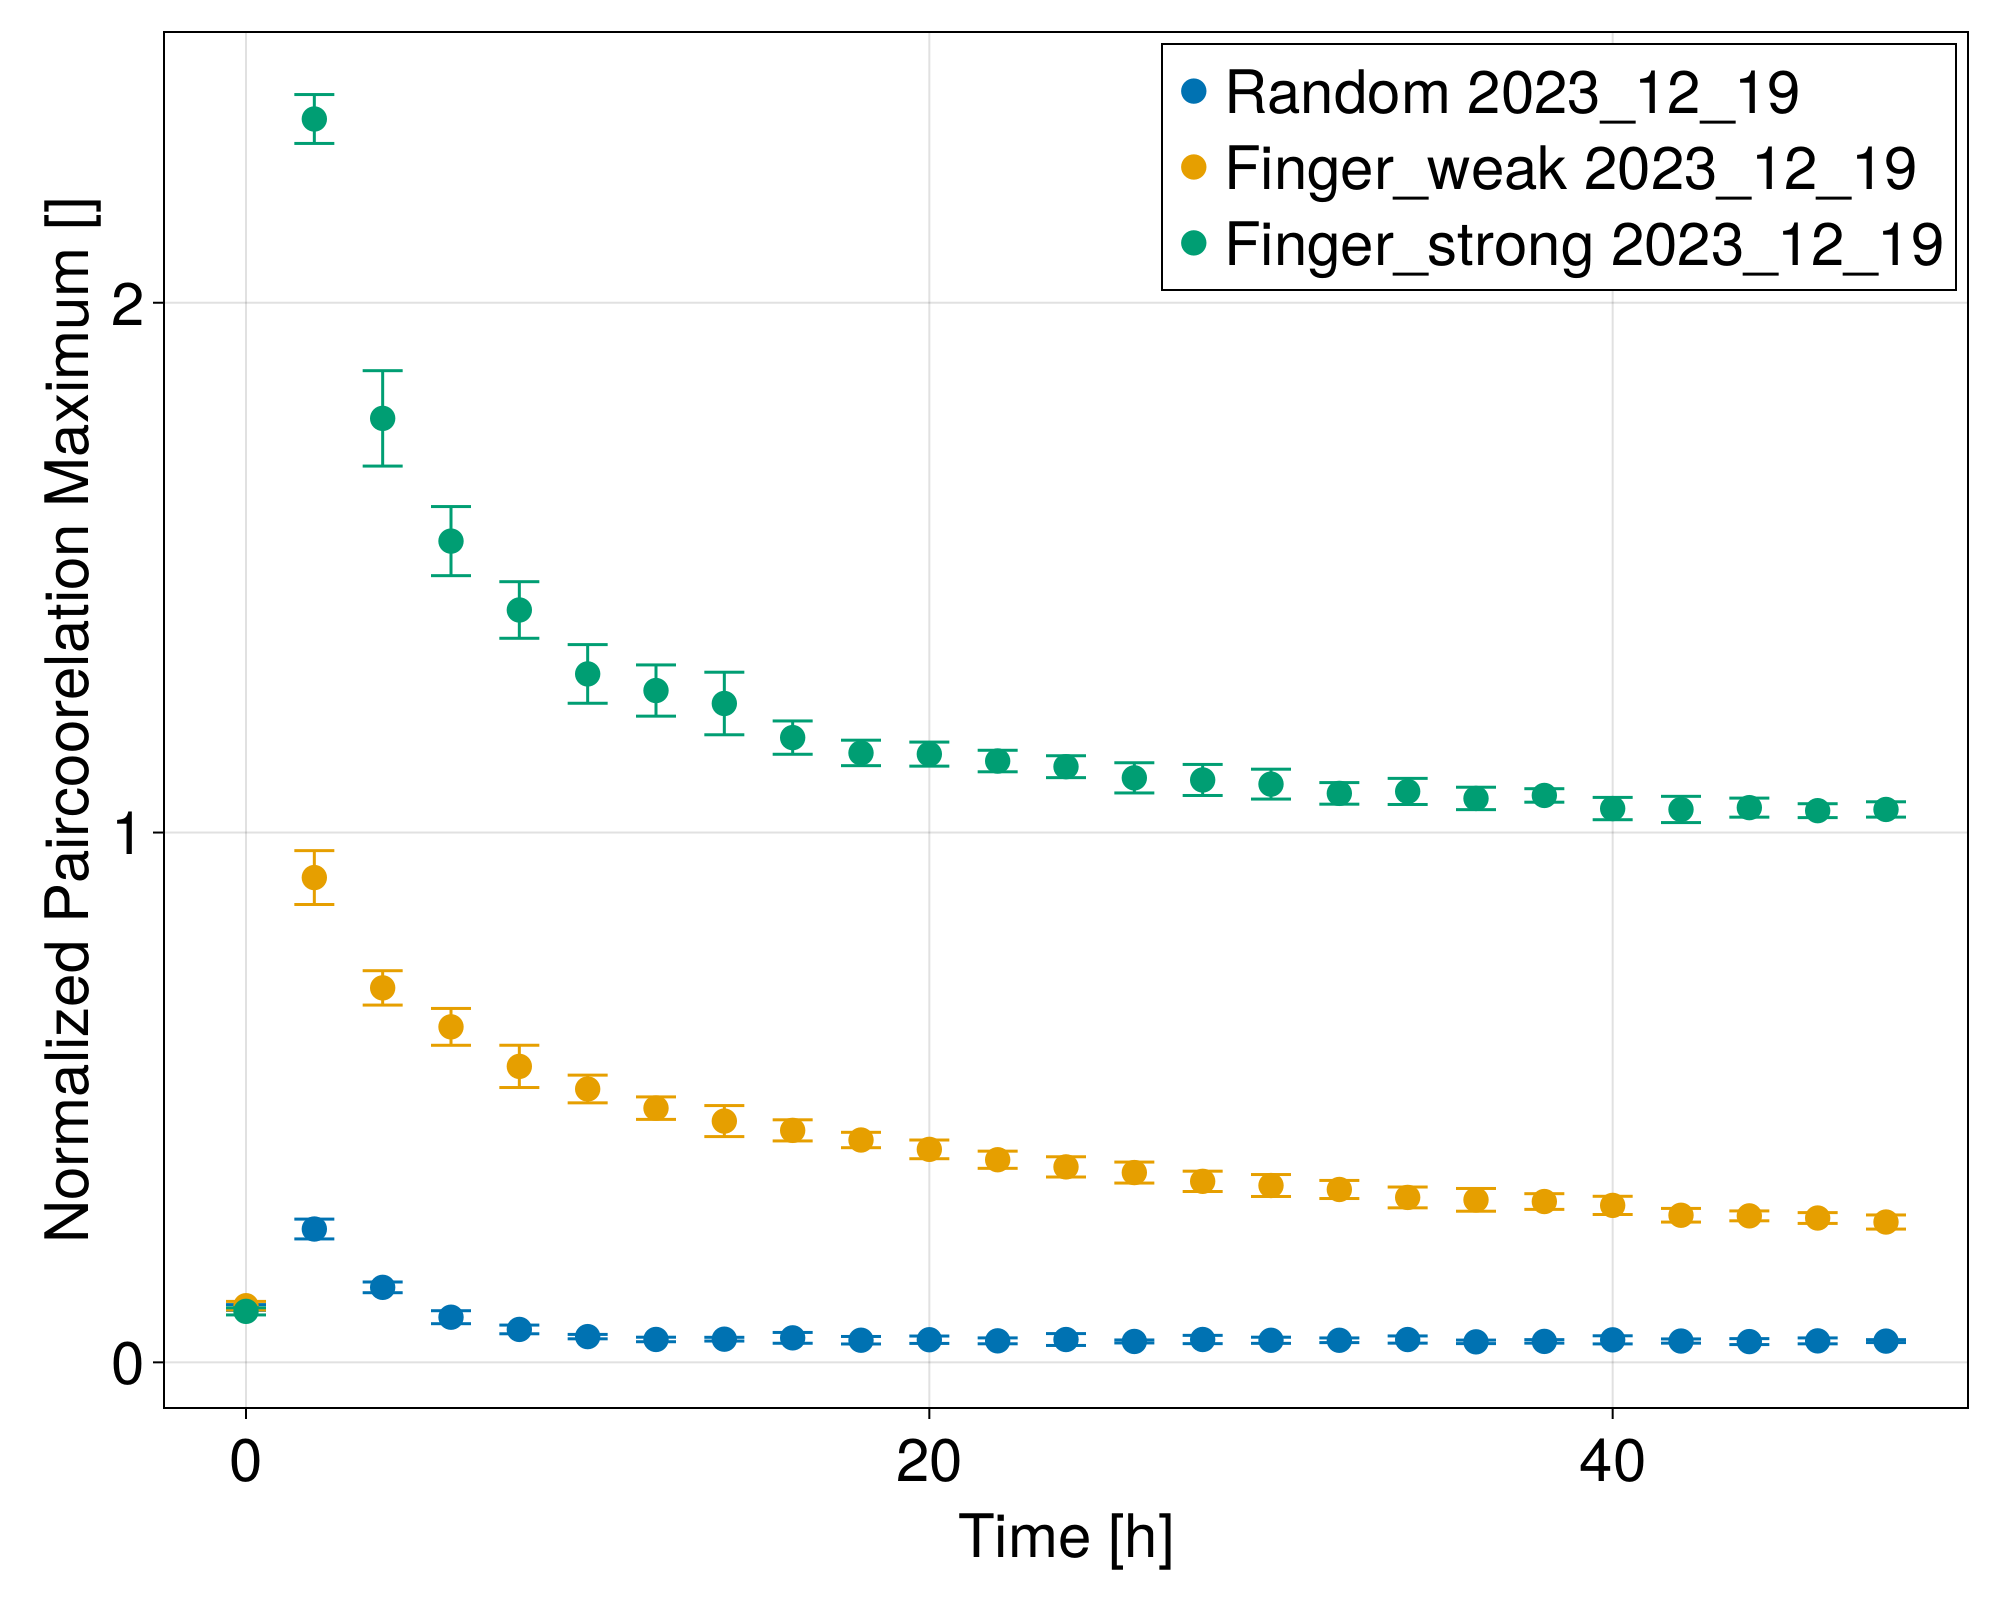

In [24]:
fig1 = Figure()
ax = CairoMakie.Axis(fig1[1,1], xlabel = "Time [h]", ylabel = "Normalized Paircoorelation Maximum []")

#errorbars!(pair_max.time,pair_max.pair_og, pair_max.pair_og_stdd,whiskerwidth = 10)

for (k, i) in pairs(groupby(pair_max_single,:data_set))
    scatter!(ax, i.time, i.pair_og, label = String(k.data_set))
    errorbars!(ax, i.time, i.pair_og,i.pair_og_stdd )
end

axislegend(ax, position = :rt)
#save(joinpath(path,"Normalized_Paircoorelation_Maximum_inidvidual.png"),fig1)
fig1

In [19]:
pair_max_r = @chain data_full begin
    #@subset(:data_set .== "14_06_23_stacked_full_res")
    groupby(:time)
     @combine(:pair_og = mean((maximum.(:pair_OG).-mean.(:pair_OG))./mean.(:pair_OG)),
        :pair_og_stdd =std((maximum.(:pair_OG).-mean.(:pair_OG))./mean.(:pair_OG)) )
end

Row,time,pair_og,pair_og_stdd
,Int64,Float64,Float64
1,0,0.0590085,0.0193867
2,3,0.534521,0.406161
3,4,0.603532,0.221662
4,19,0.458936,0.274609
5,20,0.318402,0.1617
6,24,0.684652,0.22927
7,43,1.12358,0.163496
8,44,1.01706,0.190581
9,48,1.25448,0.281709


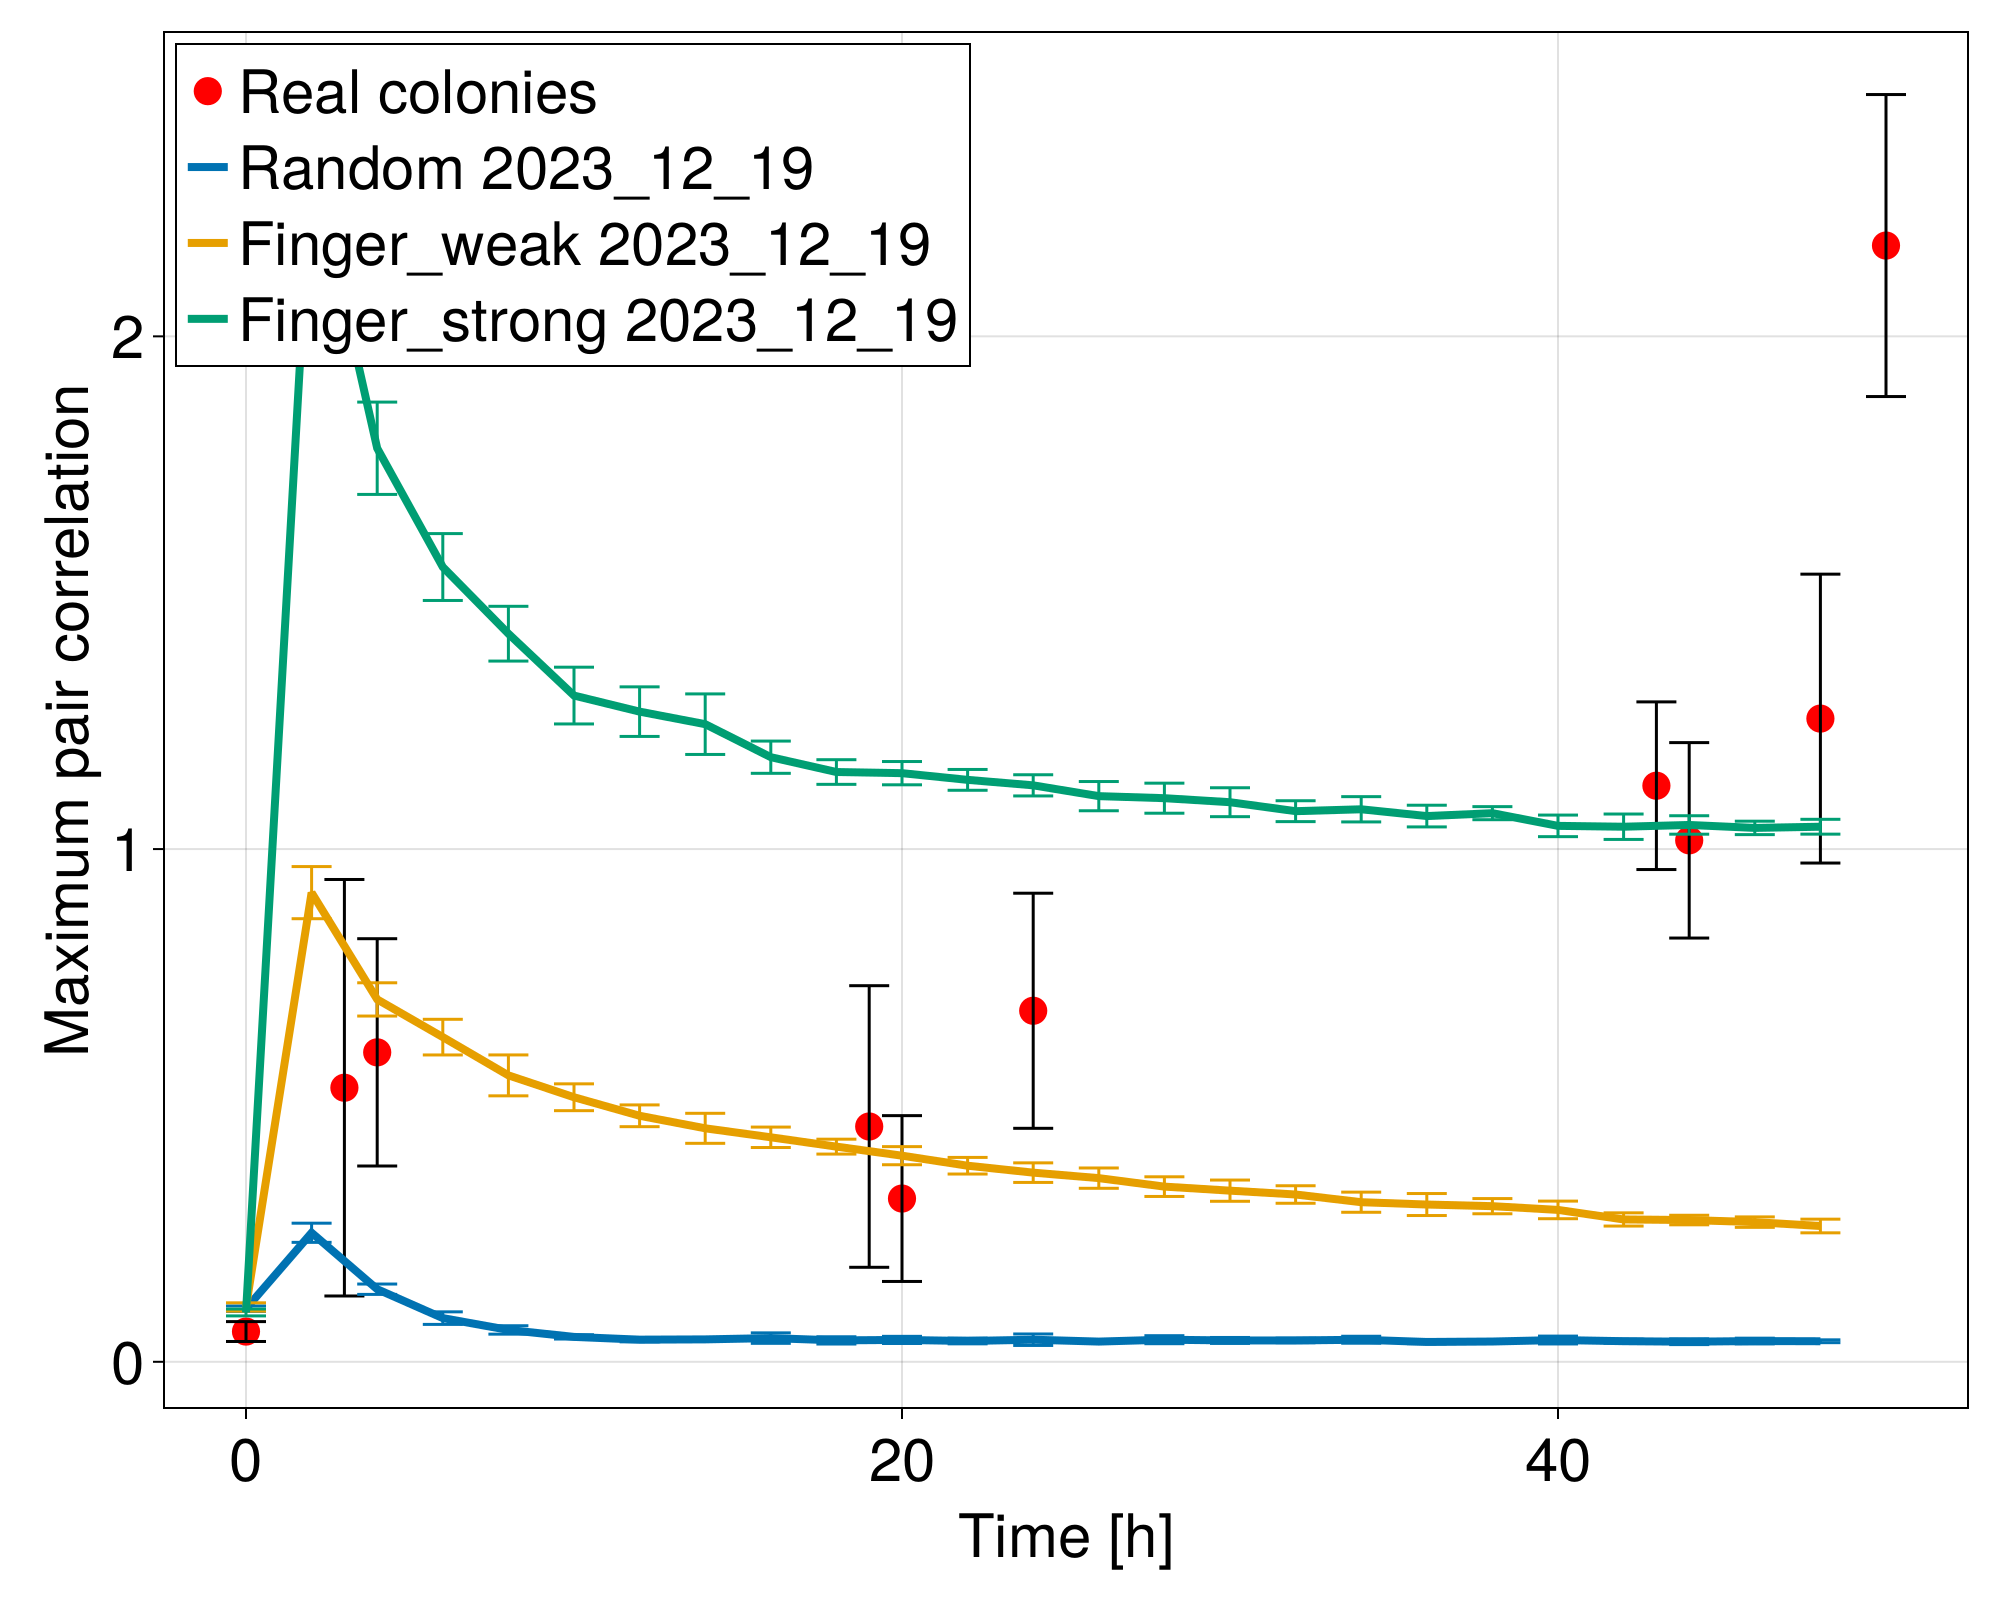

In [20]:
fig1 = Figure()
ax = CairoMakie.Axis(fig1[1,1])
scatter!(ax,pair_max_r.time,pair_max_r.pair_og, label = "Real colonies", markersize = 20, color = "red")
errorbars!(ax,pair_max_r.time,pair_max_r.pair_og, pair_max_r.pair_og_stdd,whiskerwidth = 20, color = :black)
ax.xlabel ="Time [h]"
ax.ylabel ="Maximum pair correlation"
j = 1
for (k, i) in pairs(groupby(pair_max_single,:data_set))
    lines!(ax, i.time, i.pair_og, label = i.data_set[1],linewidth = 4)
    errorbars!(ax, i.time, i.pair_og,i.pair_og_stdd )
    j += 1
end
axislegend(ax, position = :lt)
save(joinpath(path,"Comparision Normalized_Paircoorelation_Maximum_no_unit.png"),fig1)
fig1

## root mean square fluctations

In [26]:
length(data_a.metric_OG[11])

360

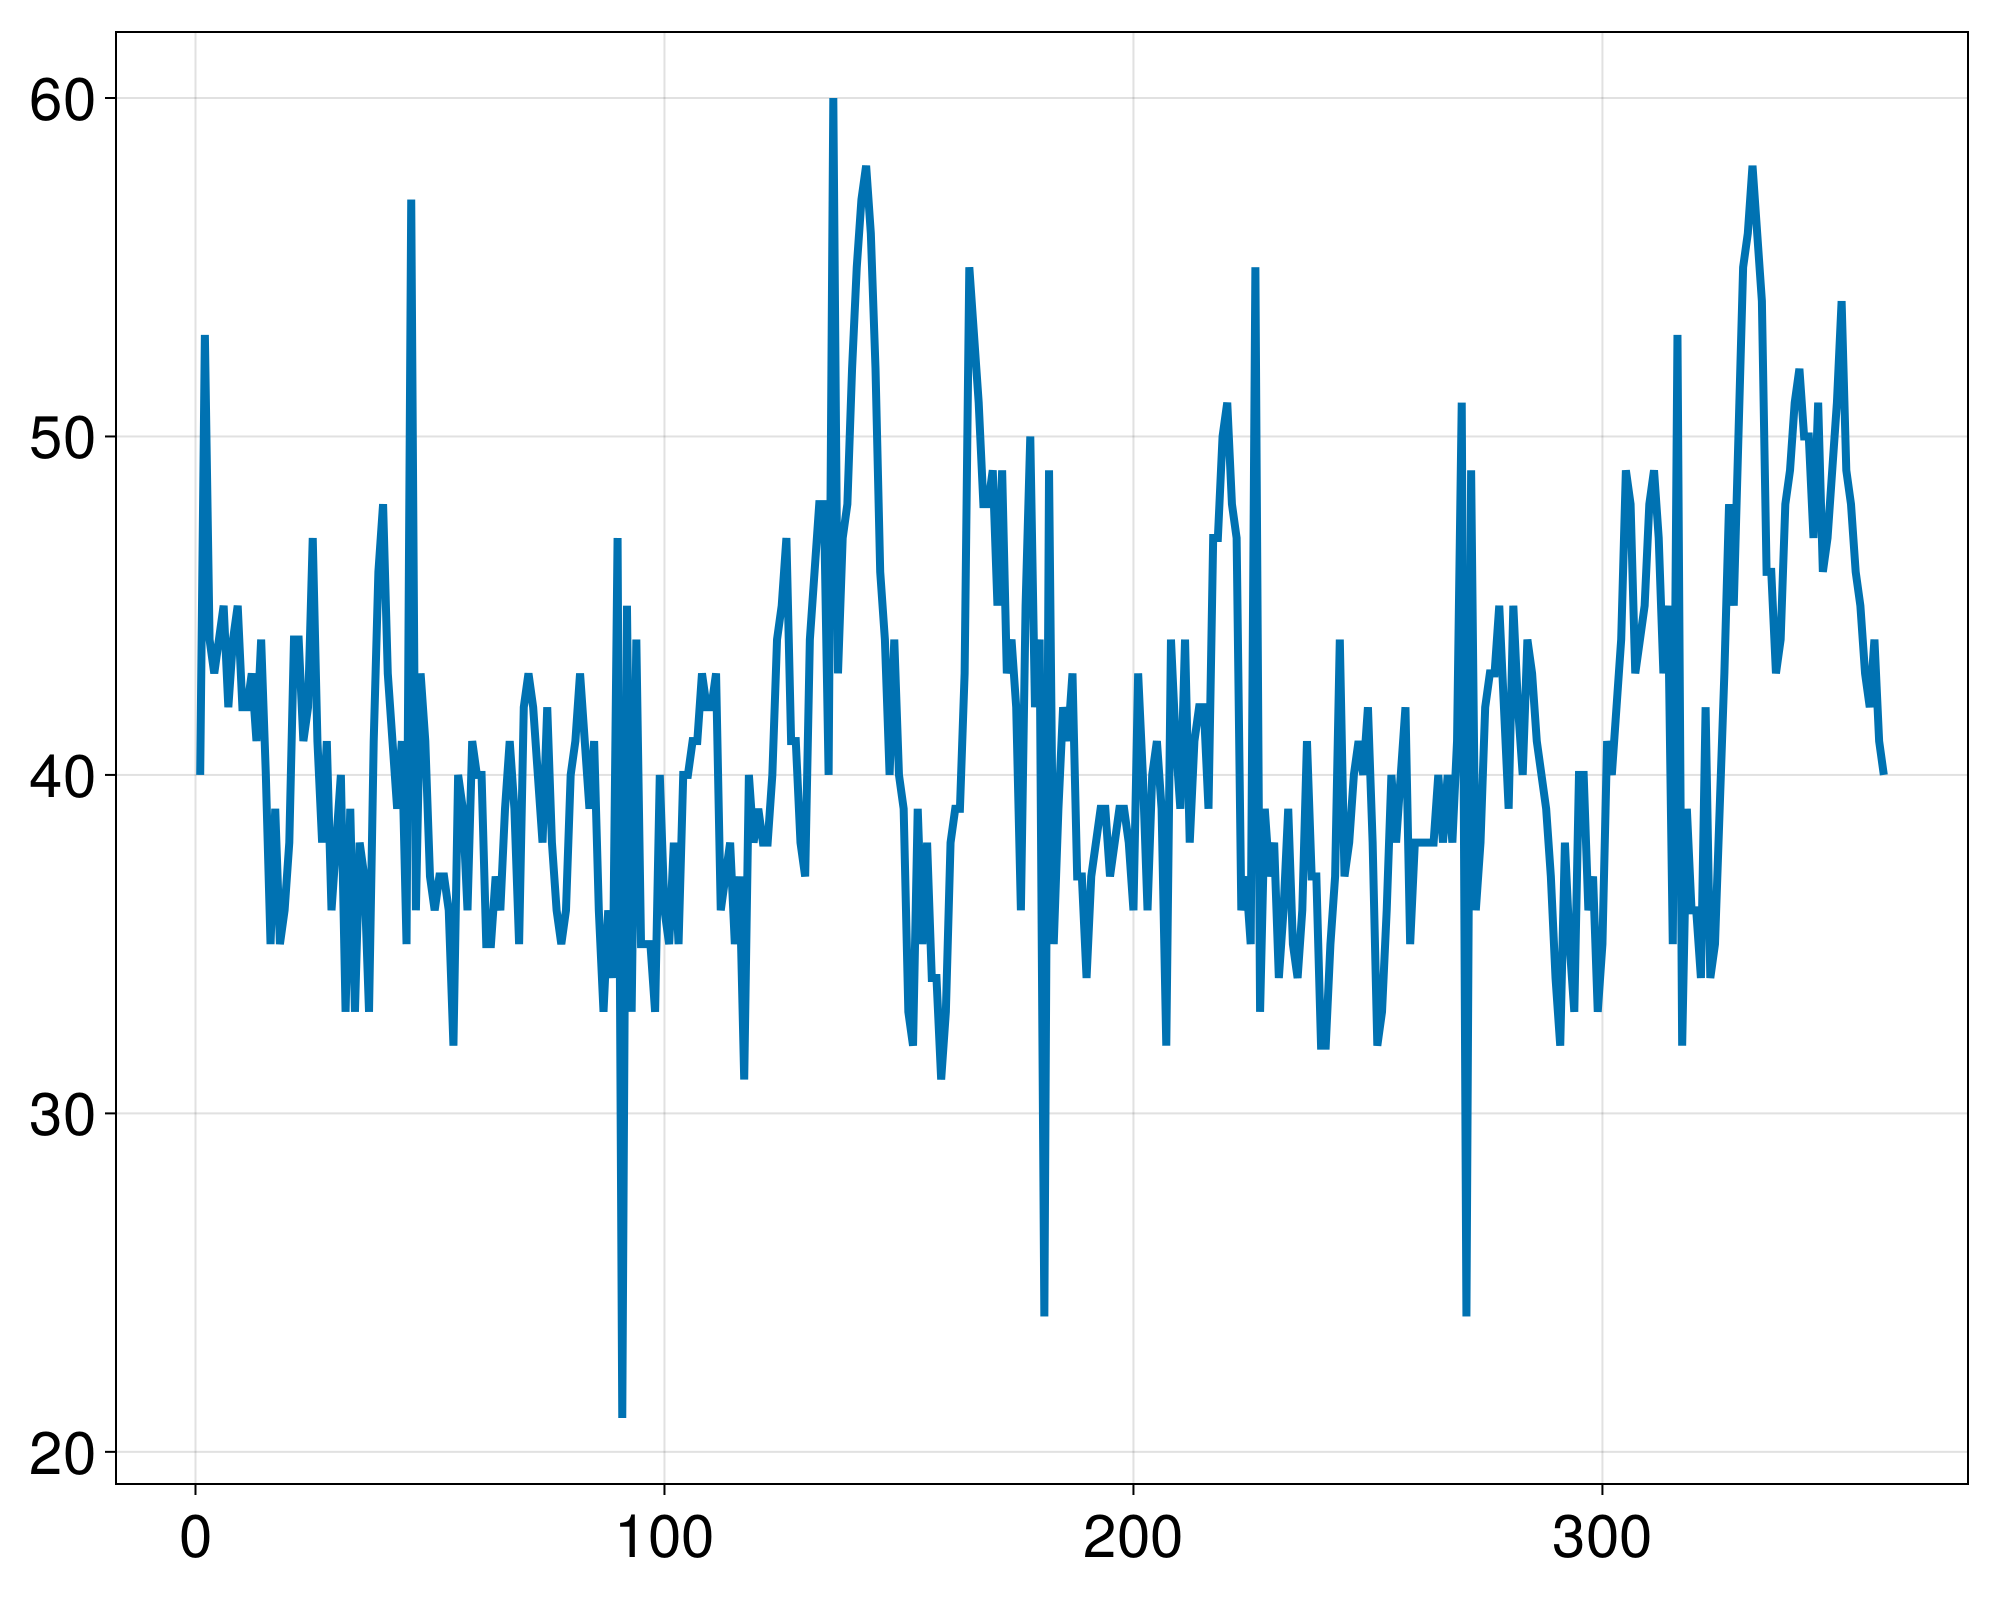

In [28]:
lines(data_a.metric_OG[110])

In [30]:
std(data_a.metric_OG[11])

5.418913540132538

In [31]:
RMS_single = @chain data_a begin
    groupby([:time,:data_set])
    @combine(:RMS_OG = mean((std.(:metric_OG))),
    :RMS_cov = mean((std.(:metric_cov))), )
end

first(RMS_single)

Row,time,data_set,RMS_OG,RMS_cov
,Int64,String,Float64,Float64
1,0,Random 2023_12_19,0.0,4.75698


In [32]:
unique(RMS_single.data_set)

3-element Vector{String}:
 "Random 2023_12_19"
 "Finger_weak 2023_12_19"
 "Finger_strong 2023_12_19"

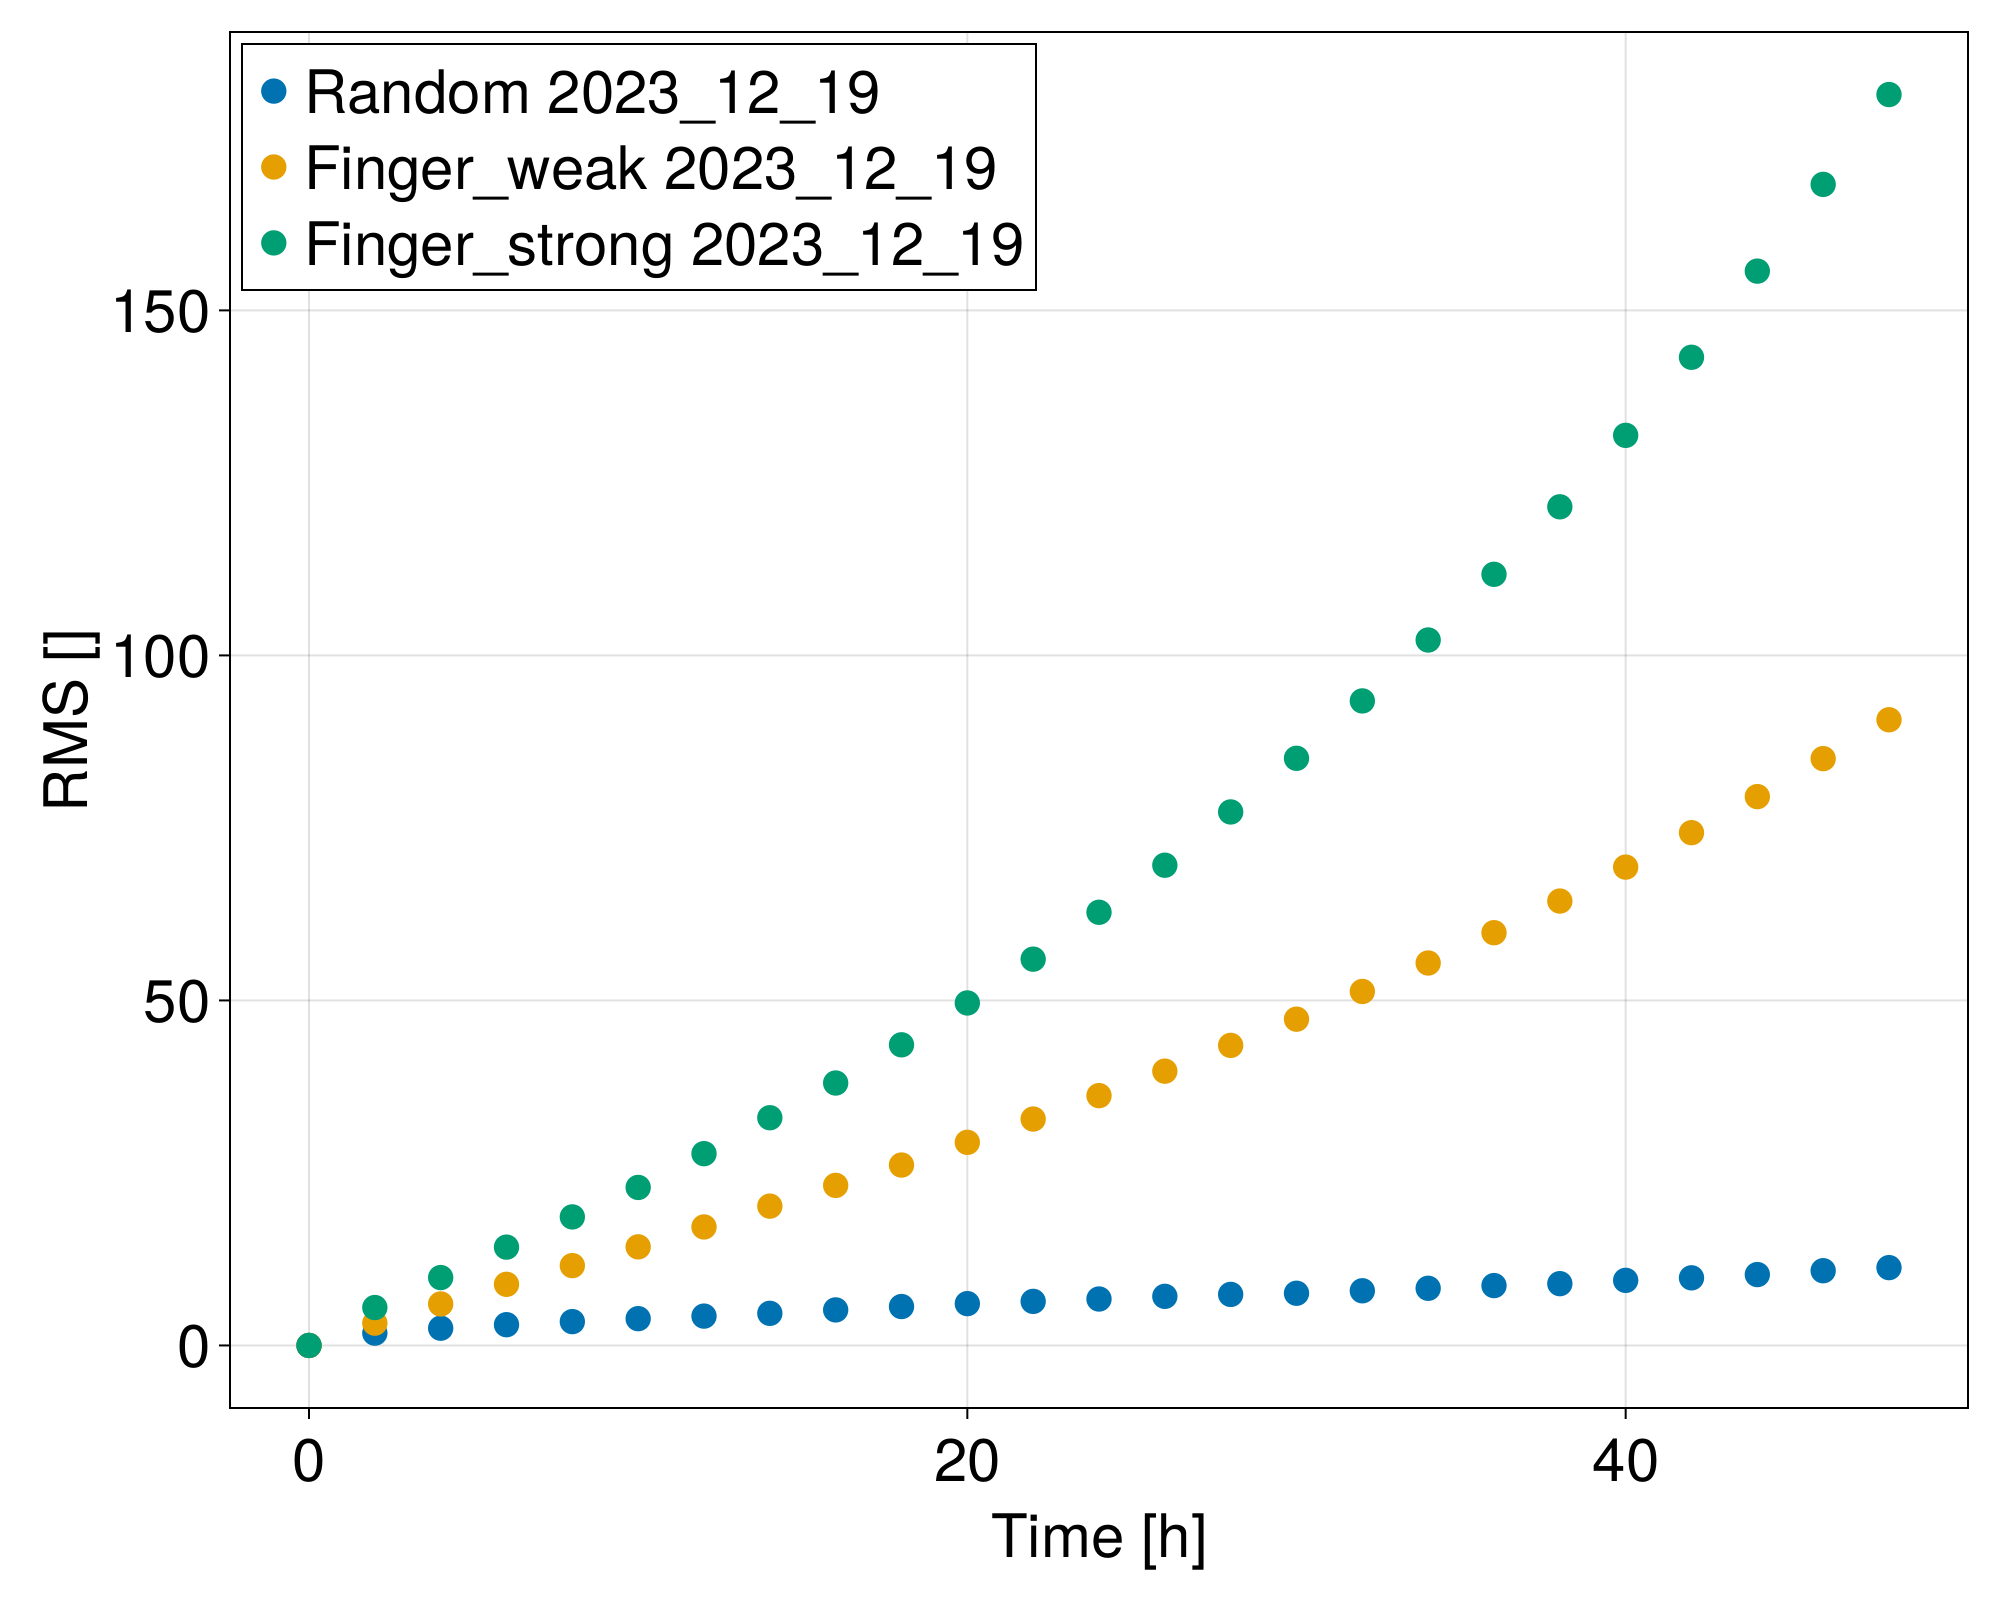

In [33]:
fig11 = Figure()
ax = CairoMakie.Axis(fig11[1,1])
for (k, i) in pairs(groupby(RMS_single,:data_set))
    scatter!(ax, i.time, i.RMS_OG, label = String(k.data_set))
    #errorbars!(ax, i.time, i.RMS_OG,i.pair_og_stdd )
end
ax.xlabel ="Time [h]"
ax.ylabel ="RMS []"
axislegend(ax, position = :lt)
#save(joinpath(path,"Normalized_Paircoorelation_Maximum_inidvidual.png"),fig1)
fig11

In [52]:
RMS_single_r = @chain data_full begin
    groupby([:time,:data_set])
    @combine(:RMS_OG = mean((std.(:metric_OG))),
    :RMS_cov = mean((std.(:metric_cov))), )
end

first(RMS_single_r)

Row,time,data_set,RMS_OG,RMS_cov
,Int64,String,Float64,Float64
1,0,14_06_23_stacked_full_res,0.0,6.17362


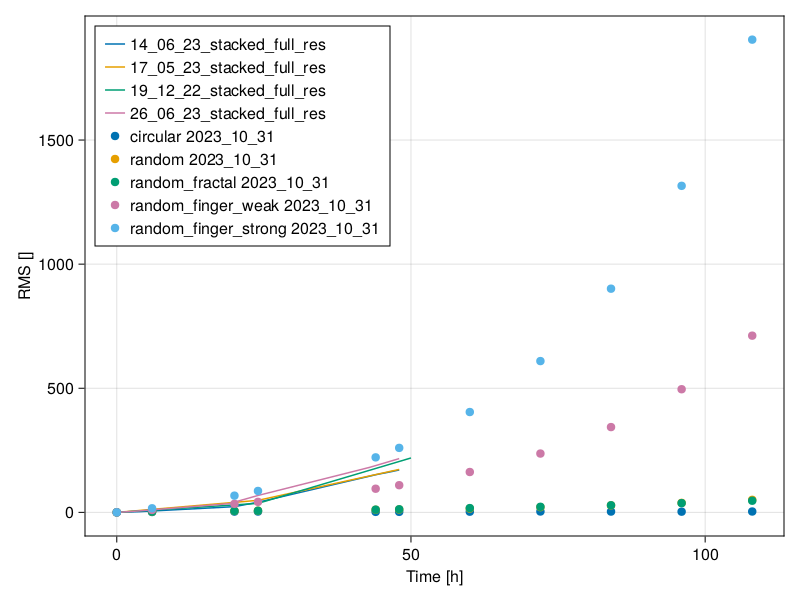

In [56]:
fig12 = Figure()
ax = CairoMakie.Axis(fig12[1,1])

for (k, i) in pairs(groupby(RMS_single_r,:data_set))
    lines!(ax, i.time, i.RMS_OG, label = String(k.data_set))
    #errorbars!(ax, i.time, i.RMS_OG,i.pair_og_stdd )
end

for (k, i) in pairs(groupby(RMS_single,:data_set))
    scatter!(ax, i.time, i.RMS_OG, label = String(k.data_set))
    #errorbars!(ax, i.time, i.RMS_OG,i.pair_og_stdd )
end
ax.xlabel ="Time [h]"
ax.ylabel ="RMS []"
axislegend(ax, position = :lt)
#save(joinpath(path,"Normalized_Paircoorelation_Maximum_inidvidual.png"),fig1)
fig12

In [34]:
first(data,3)

Row,data_set,colony,time,metric_OG,metric_cov,pair_OG,pair_cov,OG_size
,String,String,Int64,Array…,Array…,Array…,Array…,Int64
1,circular 2023_10_31,Colony 1 artifical,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0 … 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[63, 46, 59, 53, 58, 57, 57, 58, 56, 62 … 53, 62, 56, 58, 57, 57, 58, 53, 59, 63]","[5460, 5621, 5511, 5481, 5631, 5509, 5653, 5638, 5562, 5691 … 5591, 5560, 5525, 5518, 5501, 5663, 5511, 5620, 5557, 5513]","[5455, 5553, 5536, 5566, 5616, 5463, 5689, 5495, 5573, 5499 … 5468, 5578, 5543, 5579, 5592, 5513, 5568, 5509, 5658, 5507]",20589
2,circular 2023_10_31,Colony 1 artifical,6,"[12, 16, 8, 15, 9, 13, 10, 11, 11, 11 … 11, 11, 11, 11, 10, 13, 9, 15, 8, 12]","[0, 0, 0, 0, 0, 0, 2, 1, 2, 0 … 1, 0, 2, 1, 2, 0, 0, 0, 0, 0]","[4856, 5829, 5687, 5225, 5522, 5755, 5648, 5432, 5341, 5782 … 5679, 5507, 5402, 5587, 5841, 5390, 5179, 5733, 5862, 5297]","[0, 8034, 6308, 3240, 5926, 7654, 6226, 4253, 4967, 6792 … 6852, 5043, 4357, 6294, 7672, 5873, 3192, 6369, 7853, 6955]",20589
3,circular 2023_10_31,Colony 1 artifical,20,"[42, 56, 45, 48, 46, 46, 45, 44, 46, 46 … 45, 46, 46, 44, 45, 46, 46, 48, 45, 42]","[0, 0, 0, 0, 0, 0, 2, 2, 0, 0 … 2, 0, 0, 2, 2, 0, 0, 0, 0, 0]","[5319, 5669, 5420, 5498, 5676, 5652, 5475, 5401, 5587, 5637 … 5487, 5475, 5514, 5661, 5638, 5655, 5783, 5568, 5621, 5589]","[340, 6069, 6588, 5547, 5096, 6140, 6904, 5541, 5749, 7199 … 7225, 5894, 5552, 6807, 6121, 5091, 5645, 6548, 6039, 6888]",20589


In [35]:
cv_angular_max = @chain data begin
    groupby(:time)
    @combine(:cv_angu = mean(std.(:metric_cov)./(mean.(:metric_cov))))
    
    
end

Row,time,cv_angu
,Int64,Float64
1,0,0.0831762
2,6,0.89743
3,20,0.935233
4,24,0.820341
5,44,0.82959
6,48,0.883545
7,60,0.782132
8,72,0.817616
9,84,0.782002


In [27]:
cv_angular_max_single = @chain data begin 
    groupby([:time,:data_set])
    @combine(:cv_angu = mean(std.(:metric_cov)./(mean.(:metric_cov))))
end

Row,time,data_set,cv_angu
,Int64,String,Float64
1,0,circular 2023_09_14,0.116954
2,6,circular 2023_09_14,0.724817
3,20,circular 2023_09_14,0.86883
4,24,circular 2023_09_14,0.294382
5,44,circular 2023_09_14,0.379918
6,48,circular 2023_09_14,0.65605
7,0,random 2023_09_14,0.116954
8,6,random 2023_09_14,0.672764
9,20,random 2023_09_14,0.659488


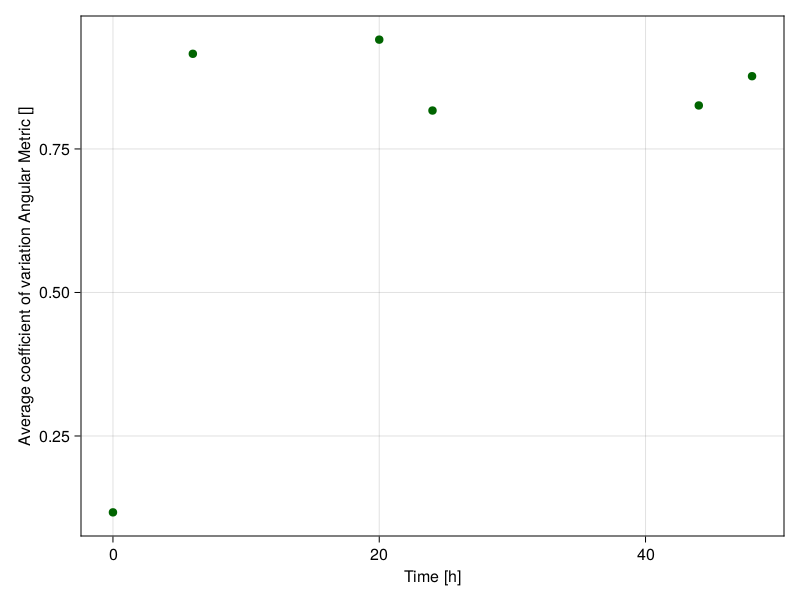

In [28]:
fig2 = scatter(cv_angular_max.time,cv_angular_max.cv_angu, color = "darkgreen", whiskerwidth = 10)
#errorbars!(cv_angu.time,cv_angular_max.cv_angu, ,whiskerwidth = 10)
fig2.axis.xlabel ="Time [h]"
fig2.axis.ylabel ="Average coefficient of variation Angular Metric []"
save(joinpath(path,"Average coefficient of variation Angular Metric.png"),fig2)

fig2

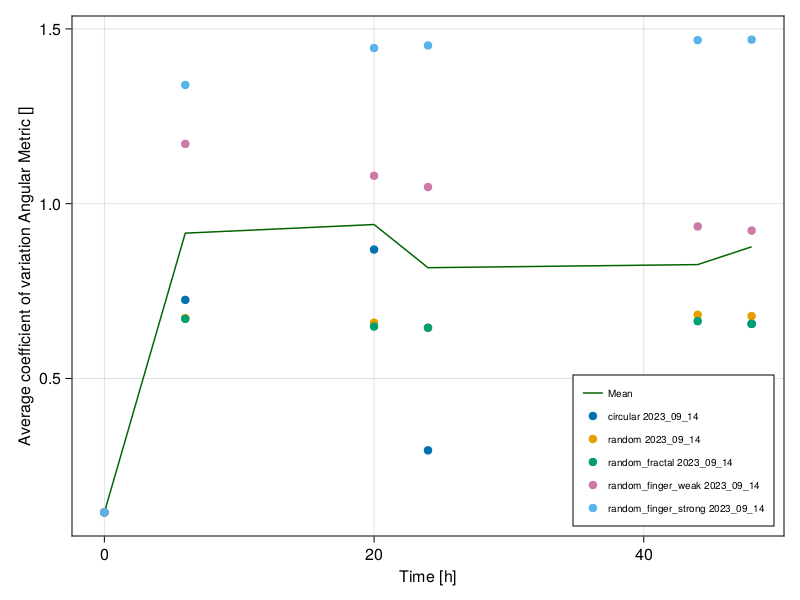

In [29]:
fig2 = lines(cv_angular_max.time,cv_angular_max.cv_angu, color = "darkgreen", whiskerwidth = 10, label = "Mean")
#scatter!(fig4.axis,abs_fftw.time,abs_fftw.abs_cov_n, color = "red", whiskerwidth = 10)
#errorbars!(cv_angu.time,cv_angular_max.cv_angu, ,whiskerwidth = 10)
for (k, i) in pairs(groupby(cv_angular_max_single,:data_set))
    scatter!(fig2.axis, i.time, i.cv_angu, label = String(k.data_set))
end
fig2.axis.xlabel ="Time [h]"
fig2.axis.ylabel ="Average coefficient of variation Angular Metric []"
save(joinpath(path,"Average coefficient of variation Angular Metric.png"),fig2)
axislegend(fig2.axis, position = :rb, labelsize = 10)
fig2

In [30]:
cv_angular_max_r = @chain data_full begin
    groupby(:time)
    @combine(:cv_OG = mean(std.(:metric_OG)./(mean.(:metric_OG))),:cv_OG_std = std(std.(:metric_OG)./(mean.(:metric_OG))))
end

Row,time,cv_OG,cv_OG_std
,Int64,Float64,Float64
1,0,NaN,NaN
2,3,0.695513,0.237475
3,4,0.720371,0.135934
4,19,0.639922,0.231289
5,20,0.548096,0.151844
6,24,0.818629,0.145498
7,43,1.06527,0.0807563
8,44,1.01741,0.09607
9,48,1.12087,0.124787


In [31]:
labels_arti = ["Simulated Random Growth", "Simulated Weak Finger Growth", "Simulated Strong Finger Growth"]
#without circular and fractal 
cv_angular_max_single_reduced = @rsubset(cv_angular_max_single, :data_set in ["random_finger_strong 2023_09_14",
        "random_finger_weak 2023_09_14","random 2023_09_14"])

Row,time,data_set,cv_angu
,Int64,String,Float64
1,0,random 2023_09_14,0.116954
2,6,random 2023_09_14,0.672764
3,20,random 2023_09_14,0.659488
4,24,random 2023_09_14,0.64493
5,44,random 2023_09_14,0.68221
6,48,random 2023_09_14,0.678565
7,0,random_finger_weak 2023_09_14,0.116954
8,6,random_finger_weak 2023_09_14,1.17104
9,20,random_finger_weak 2023_09_14,1.07987


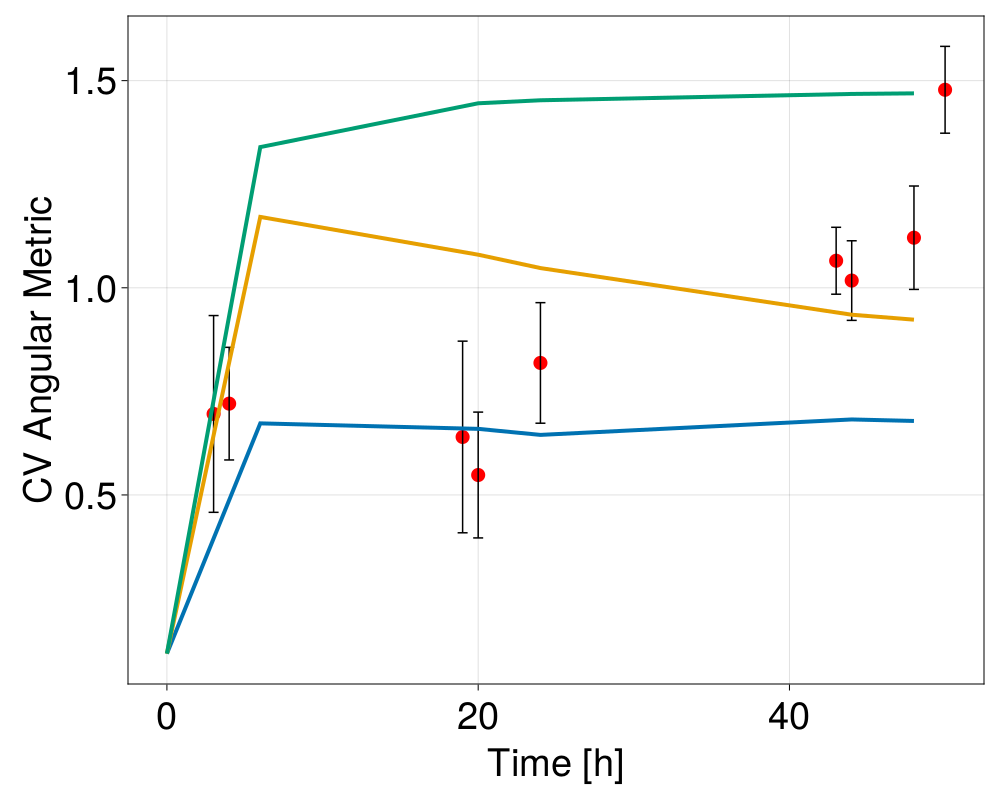

In [32]:
fig3 = Figure(fontsize = 38,resolution = (1000,800))
ax = CairoMakie.Axis(fig3[1,1])
scatter!(ax,cv_angular_max_r.time,cv_angular_max_r.cv_OG, label = "Real colonies", markersize = 20, color = "red")
errorbars!(ax,cv_angular_max_r.time,cv_angular_max_r.cv_OG, cv_angular_max_r.cv_OG_std,whiskerwidth = 10)
ax.xlabel ="Time [h]"
ax.ylabel ="CV Angular Metric"
j = 1
for (k, i) in pairs(groupby(cv_angular_max_single_reduced,:data_set))
    lines!(ax, i.time, i.cv_angu, label = labels_arti[j],linewidth =4)
    #errorbars!(ax, i.time, i.pair_og,i.pair_og_stdd )
    j += 1
end
#Legend(fig3[2,1],ax)
save(joinpath(path,"Comparision coefficent of variatoion_yes_no_unit.png"),fig3)
fig3

In [39]:
roughness_angular_max_single = @chain data begin 
    groupby([:time,:data_set])
    @combine(:roughness_angu = mean(std.(:metric_cov)))
end
first(roughness_angular_max_single)

Row,time,data_set,roughness_angu
,Int64,String,Float64
1,0,circular 2023_09_14,6.68882


In [40]:
labels_arti = ["Circular Growth","Simulated Random Growth","Random Fractal", "Simulated Weak Finger Growth", "Simulated Strong Finger Growth"]

5-element Vector{String}:
 "Circular Growth"
 "Simulated Random Growth"
 "Random Fractal"
 "Simulated Weak Finger Growth"
 "Simulated Strong Finger Growth"

In [41]:
roughness_angular_max_r = @chain data_full begin
    groupby(:time)
    @combine(:roughness_OG = mean(std.(:metric_OG)),:roughness_OG_std = std(std.(:metric_OG)))
end

Row,time,roughness_OG,roughness_OG_std
,Int64,Float64,Float64
1,0,0.0,0.0
2,3,4.52467,4.76343
3,4,3.01044,1.35788
4,19,34.7599,21.9436
5,20,23.0157,7.95766
6,24,48.8446,23.8872
7,43,181.523,33.9552
8,44,151.611,29.2072
9,48,185.017,52.0155


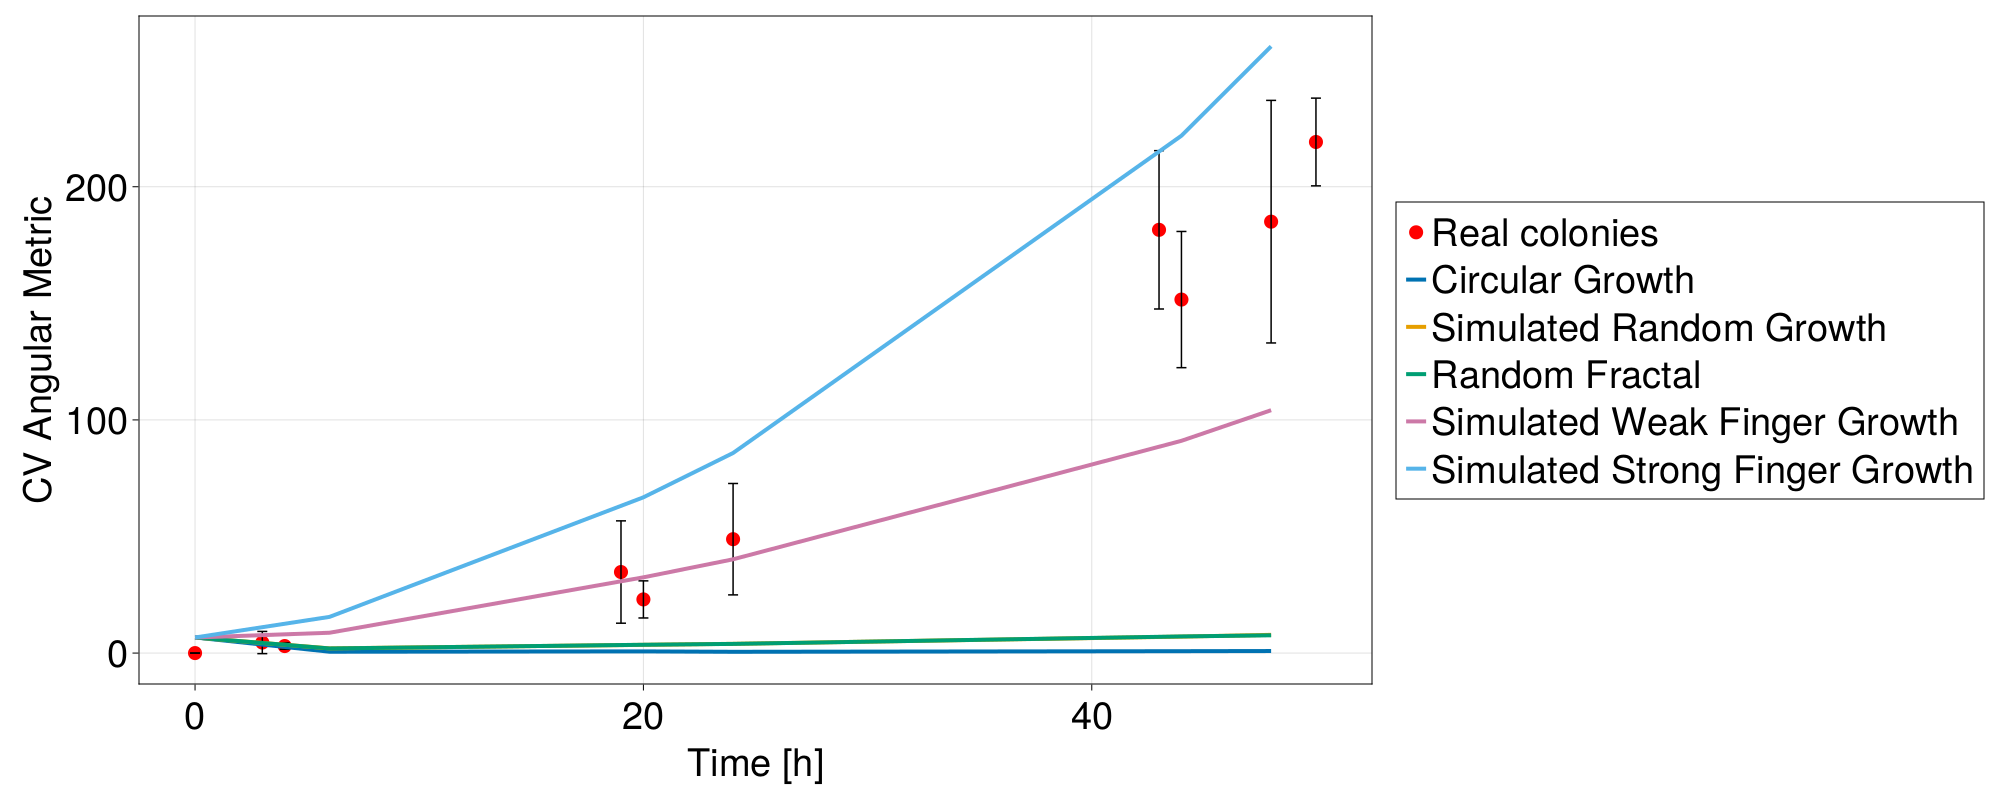

In [46]:
fig30 = Figure(fontsize = 38,resolution = (2000,800))
ax = CairoMakie.Axis(fig30[1,1])
scatter!(ax,roughness_angular_max_r.time,roughness_angular_max_r.roughness_OG, label = "Real colonies", markersize = 20, color = "red")
errorbars!(ax,roughness_angular_max_r.time,roughness_angular_max_r.roughness_OG, roughness_angular_max_r.roughness_OG_std,whiskerwidth = 10)
ax.xlabel ="Time [h]"
ax.ylabel ="CV Angular Metric"
j = 1
for (k, i) in pairs(groupby(roughness_angular_max_single,:data_set))
    lines!(ax, i.time, i.roughness_angu, label = labels_arti[j],linewidth =4)
    #errorbars!(ax, i.time, i.pair_og,i.pair_og_stdd )
    j += 1
end
Legend(fig30[1,2],ax)
#save(joinpath(path,"Comparision coefficent of variatoion_yes_no_unit.png"),fig3)
fig30

In [47]:
pairs(groupby(roughness_angular_max_single,:data_set))

Base.Generator{Base.Iterators.Zip{Tuple{DataFrames.GroupKeys{GroupedDataFrame{DataFrame}}, GroupedDataFrame{DataFrame}}}, Base.var"#6#7"{Pair}}(Base.var"#6#7"{Pair}(), zip(DataFrames.GroupKey{GroupedDataFrame{DataFrame}}[GroupKey: (data_set = "circular 2023_09_14",), GroupKey: (data_set = "random 2023_09_14",), GroupKey: (data_set = "random_fractal 2023_09_14",), GroupKey: (data_set = "random_finger_weak 2023_09_14",), GroupKey: (data_set = "random_finger_strong 2023_09_14",)], GroupedDataFrame with 5 groups based on key: data_set
First Group (6 rows): data_set = "circular 2023_09_14"
 Row │ time   data_set             roughness_angu 
     │ Int64  String               Float64        
─────┼────────────────────────────────────────────
   1 │     0  circular 2023_09_14        6.68882
   2 │     6  circular 2023_09_14        0.58388
   3 │    20  circular 2023_09_14        0.731266
   4 │    24  circular 2023_09_14        0.551965
   5 │    44  circular 2023_09_14        0.812602
   6 │ 

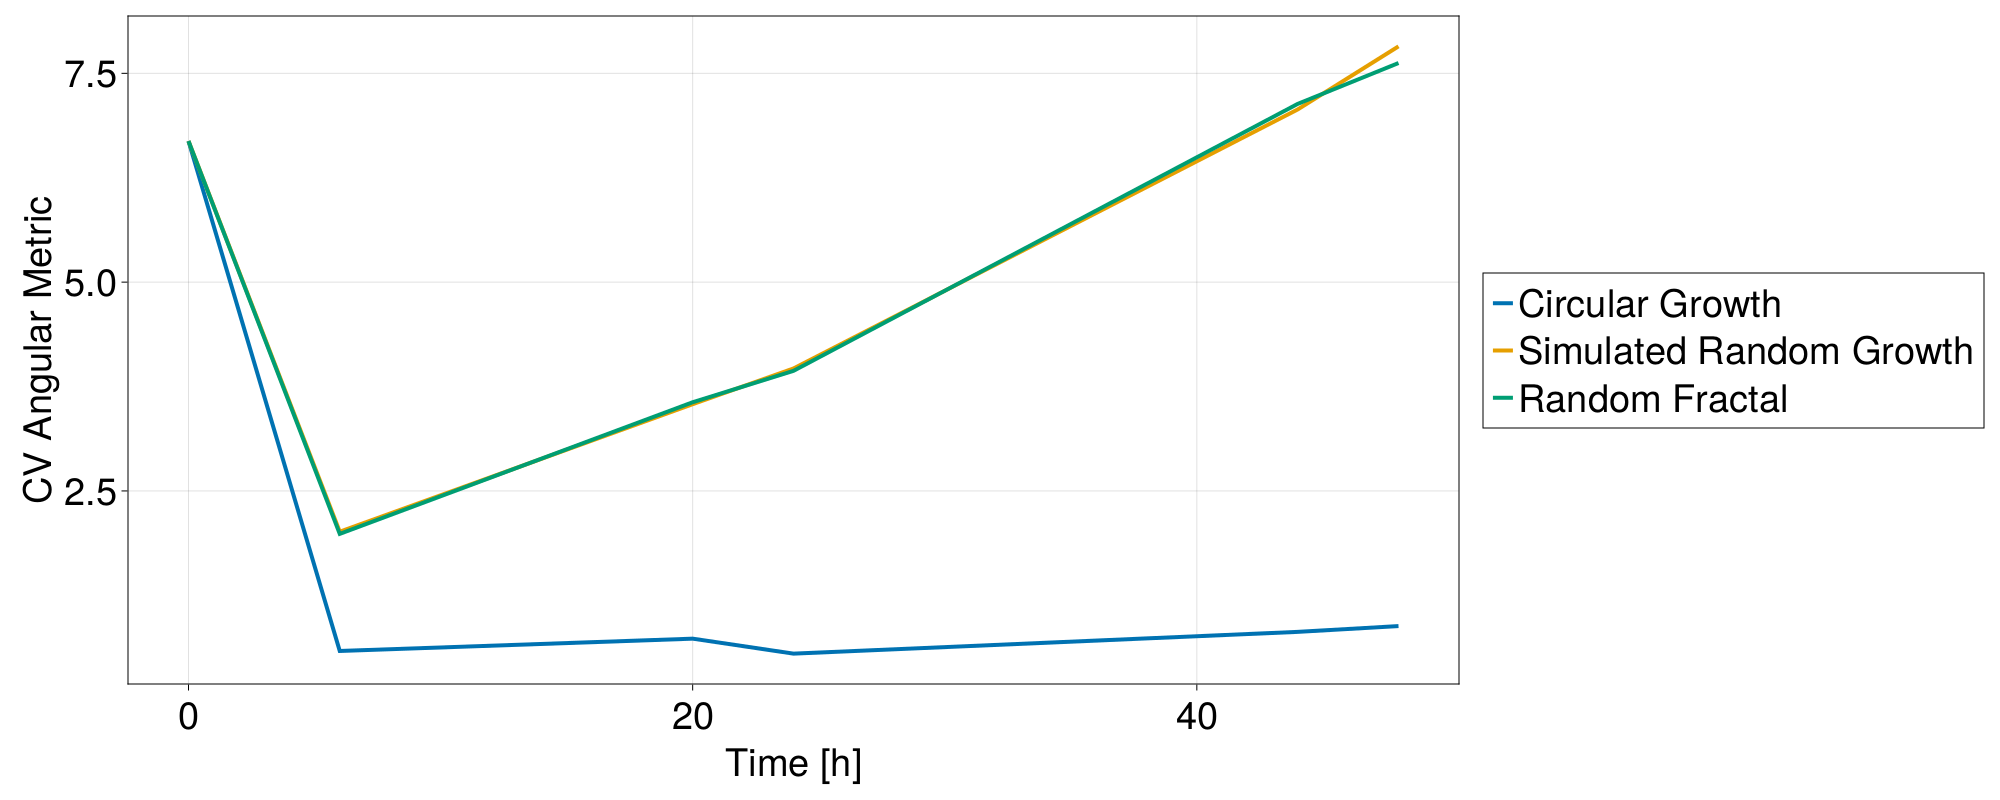

In [49]:
fig30 = Figure(fontsize = 38,resolution = (2000,800))
ax = CairoMakie.Axis(fig30[1,1])
#scatter!(ax,roughness_angular_max_r.time,roughness_angular_max_r.roughness_OG, label = "Real colonies", markersize = 20, color = "red")
#errorbars!(ax,roughness_angular_max_r.time,roughness_angular_max_r.roughness_OG, roughness_angular_max_r.roughness_OG_std,whiskerwidth = 10)
ax.xlabel ="Time [h]"
ax.ylabel ="CV Angular Metric"
j = 1
for (k, i) in pairs(groupby(roughness_angular_max_single,:data_set))
    lines!(ax, i.time, i.roughness_angu, label = labels_arti[j],linewidth =4)
    #errorbars!(ax, i.time, i.pair_og,i.pair_og_stdd )
    j += 1
    if j >3 
        break
    end
end
Legend(fig30[1,2],ax)
#save(joinpath(path,"Comparision coefficent of variatoion_yes_no_unit.png"),fig3)
fig30

In [25]:
fft_data = @chain data begin 
    @transform(:fourier_conv = (fft.(:metric_cov)), :fourier_OG = (fft.(:metric_OG)))
    @transform(:abs_cov = [abs.(x[2:360÷2]) for x in :fourier_conv], :abs_OG = [abs.(x[2:360÷2]) for x in :fourier_OG])
    @transform(:abs_cov_n = :abs_cov./:OG_size, :abs_OG_n = :abs_OG ./ :OG_size)

end
first(fft_data)

Row,data_set,colony,time,metric_OG,metric_cov,pair_OG,pair_cov,OG_size,fourier_conv,fourier_OG,abs_cov,abs_OG,abs_cov_n,abs_OG_n
,String,String,Int64,Array…,Array…,Array…,Array…,Int64,Array…,Array…,Array…,Array…,Array…,Array…
1,circular 2023_09_14,Colony 1 artifical,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0 … 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 46, 59, 53, 58, 57, 57, 58, 56, 62 … 53, 62, 56, 58, 57, 57, 58, 53, 59, 126]","[5555, 5546, 5447, 5537, 5552, 5563, 5499, 5483, 5464, 5574 … 5552, 5656, 5490, 5499, 5625, 5594, 5572, 5551, 5542, 5373]","[5471, 5497, 5554, 5544, 5645, 5485, 5664, 5577, 5650, 5612 … 5541, 5650, 5582, 5465, 5465, 5549, 5611, 5441, 5611, 5505]",20589,"ComplexF64[20589.0+0.0im, -1.01218+1.39619im, 0.951266+2.79196im, -1.10964+4.18688im, -26.0104+5.58052im, -1.30442+6.97246im, 0.561752+8.36228im, -1.59631+9.74955im, 8.36351+11.1338im, -1.98493+12.5148im … -0.21538-13.8919im, -1.98493-12.5148im, 8.36351-11.1338im, -1.59631-9.74955im, 0.561752-8.36228im, -1.30442-6.97246im, -26.0104-5.58052im, -1.10964-4.18688im, 0.951266-2.79196im, -1.01218-1.39619im]","ComplexF64[0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im … 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im]","[1.72449, 2.94957, 4.33142, 26.6023, 7.09343, 8.38112, 9.87937, 13.9252, 12.6712, 13.8935 … 158.395, 160.504, 86.8651, 160.7, 158.782, 160.847, 97.5837, 160.945, 158.976, 160.994]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0 … 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[8.37579e-5, 0.000143259, 0.000210376, 0.00129207, 0.000344525, 0.000407068, 0.000479837, 0.000676341, 0.000615435, 0.000674803 … 0.00769318, 0.0077956, 0.00421901, 0.00780512, 0.00771199, 0.00781227, 0.0047396, 0.00781703, 0.00772139, 0.00781941]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0 … 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"


In [26]:
abs_fftw = @chain fft_data begin 
    groupby(:time)
    @combine(:abs_og = mean(sum.(:abs_OG)) , :abs_cov = mean(sum.(:abs_cov)),:abs_og_n = mean(sum.(:abs_OG_n)),:abs_cov_n = mean(sum.(:abs_cov_n)) )
end

Row,time,abs_og,abs_cov,abs_og_n,abs_cov_n
,Int64,Float64,Float64,Float64,Float64
1,0,0.0,19140.5,0.0,0.929648
2,6,14149.7,11924.4,0.687244,0.579165
3,20,45387.3,39338.5,2.20444,1.91066
4,24,56556.9,48989.1,2.74695,2.37938
5,44,1.33374e5,117463.0,6.47792,5.70514
6,48,1.54765e5,1.36179e5,7.5169,6.61418


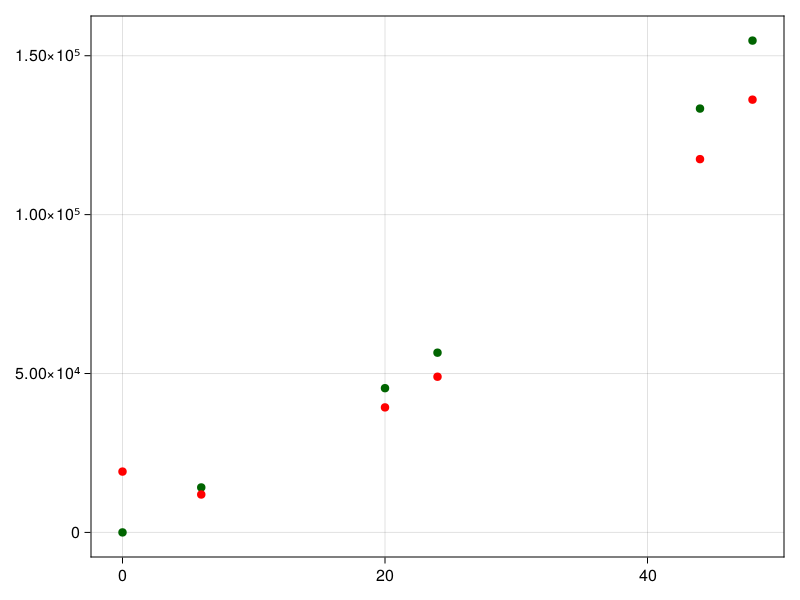

In [27]:
fig3 = scatter(abs_fftw.time,abs_fftw.abs_og, color = "darkgreen", whiskerwidth = 10)
scatter!(fig3.axis,abs_fftw.time,abs_fftw.abs_cov, color = "red", whiskerwidth = 10)
#errorbars!(cv_angu.time,cv_angular_max.cv_angu, ,whiskerwidth = 10)
fig3

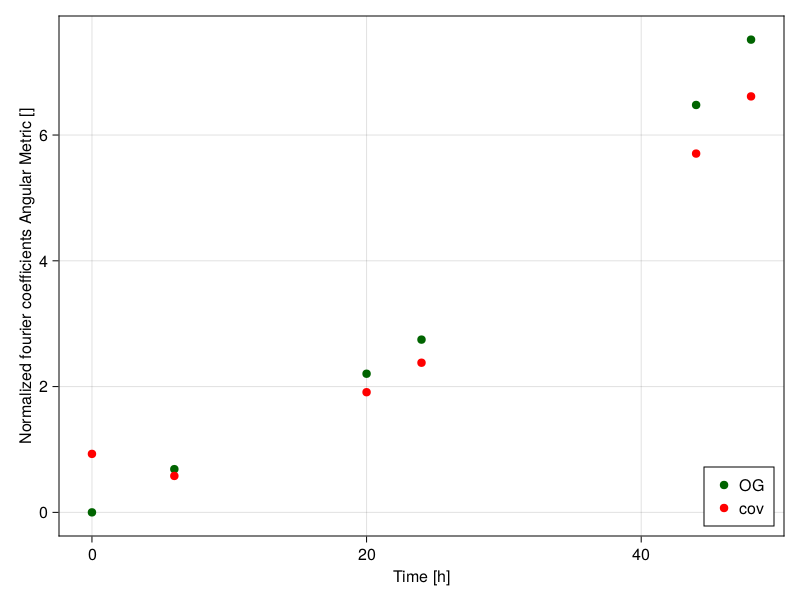

In [28]:
fig4 = scatter(abs_fftw.time,abs_fftw.abs_og_n, color = "darkgreen", whiskerwidth = 10, label = "OG")
scatter!(fig4.axis,abs_fftw.time,abs_fftw.abs_cov_n, color = "red", whiskerwidth = 10, label = "cov")
#errorbars!(cv_angu.time,cv_angular_max.cv_angu, ,whiskerwidth = 10)
fig4.axis.xlabel ="Time [h]"
fig4.axis.ylabel ="Normalized fourier coefficients Angular Metric []"

axislegend(fig4.axis, position = :rb)
save(joinpath(path,"Average Normalized fourier coefficients Angular Metric Angular Metric.png"),fig4)
fig4

### Compare different datasets: 



In [29]:
first(data,3)

Row,data_set,colony,time,metric_OG,metric_cov,pair_OG,pair_cov,OG_size
,String,String,Int64,Array…,Array…,Array…,Array…,Int64
1,circular 2023_09_14,Colony 1 artifical,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0 … 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 46, 59, 53, 58, 57, 57, 58, 56, 62 … 53, 62, 56, 58, 57, 57, 58, 53, 59, 126]","[5555, 5546, 5447, 5537, 5552, 5563, 5499, 5483, 5464, 5574 … 5552, 5656, 5490, 5499, 5625, 5594, 5572, 5551, 5542, 5373]","[5471, 5497, 5554, 5544, 5645, 5485, 5664, 5577, 5650, 5612 … 5541, 5650, 5582, 5465, 5465, 5549, 5611, 5441, 5611, 5505]",20589
2,circular 2023_09_14,Colony 1 artifical,6,"[0, 16, 8, 15, 9, 13, 10, 11, 11, 11 … 11, 11, 11, 11, 10, 13, 9, 15, 8, 24]","[0, 0, 0, 0, 0, 0, 2, 1, 2, 0 … 1, 0, 2, 1, 2, 0, 0, 0, 0, 0]","[4777, 6026, 5632, 5269, 5435, 5700, 5729, 5388, 5479, 5709 … 5670, 5398, 5345, 5526, 5728, 5488, 5298, 5737, 5884, 5304]","[0, 8078, 6309, 3269, 5931, 7992, 6130, 4269, 5048, 6783 … 6837, 5005, 4440, 6278, 7680, 5914, 3166, 6370, 7900, 6909]",20589
3,circular 2023_09_14,Colony 1 artifical,20,"[0, 56, 45, 48, 46, 46, 45, 44, 46, 46 … 45, 46, 46, 44, 45, 46, 46, 48, 45, 84]","[0, 0, 0, 0, 0, 0, 2, 2, 0, 0 … 2, 0, 0, 2, 2, 0, 0, 0, 0, 0]","[5495, 5570, 5608, 5424, 5541, 5571, 5438, 5655, 5529, 5500 … 5365, 5589, 5454, 5557, 5548, 5595, 5696, 5459, 5598, 5696]","[373, 6075, 6717, 5531, 5140, 5950, 6696, 5613, 5842, 7129 … 7042, 5796, 5691, 6824, 6000, 5175, 5608, 6477, 6174, 7005]",20589


In [30]:
abs_fftw_single = @chain fft_data begin 
    groupby([:time,:data_set])
    @combine(:abs_og = mean(sum.(:abs_OG)) , :abs_cov = mean(sum.(:abs_cov)),:abs_og_n = mean(sum.(:abs_OG_n)),:abs_cov_n = mean(sum.(:abs_cov_n)) )
end

Row,time,data_set,abs_og,abs_cov,abs_og_n,abs_cov_n
,Int64,String,Float64,Float64,Float64,Float64
1,0,circular 2023_09_14,0.0,19140.5,0.0,0.929648
2,6,circular 2023_09_14,3256.23,951.473,0.158154,0.0462127
3,20,circular 2023_09_14,9697.41,1281.44,0.471,0.062239
4,24,circular 2023_09_14,11972.4,998.716,0.581496,0.0485072
5,44,circular 2023_09_14,25997.5,1275.61,1.26269,0.0619559
6,48,circular 2023_09_14,29955.2,1460.01,1.45491,0.0709122
7,0,random 2023_09_14,0.0,19140.5,0.0,0.929648
8,6,random 2023_09_14,8391.37,5806.82,0.407565,0.282035
9,20,random 2023_09_14,17374.3,9199.02,0.843865,0.446793


In [31]:
a =0
for (k,i) in pairs(groupby(abs_fftw_single,:data_set))
    println(k)
    a = k
end


GroupKey: (data_set = "circular 2023_09_14",)
GroupKey: (data_set = "random 2023_09_14",)
GroupKey: (data_set = "random_fractal 2023_09_14",)
GroupKey: (data_set = "random_finger_weak 2023_09_14",)
GroupKey: (data_set = "random_finger_strong 2023_09_14",)


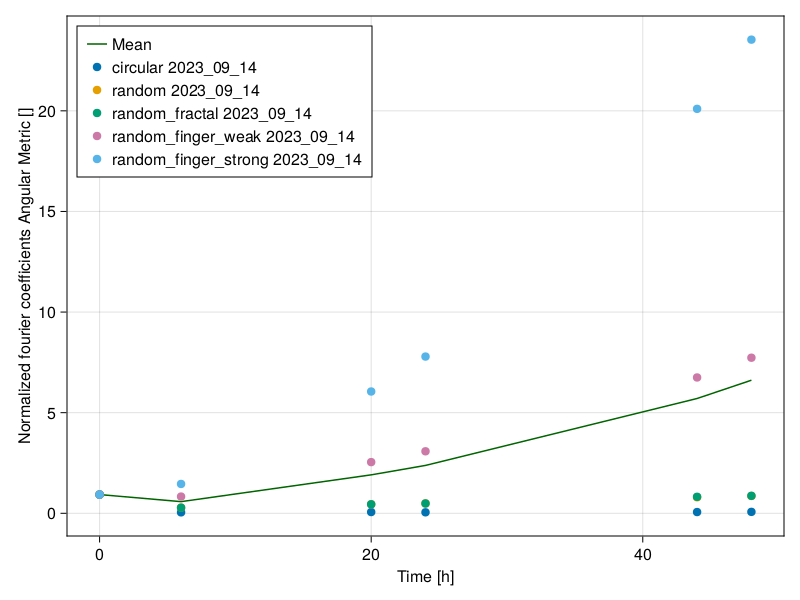

In [32]:
fig4 = lines(abs_fftw.time,abs_fftw.abs_cov_n, color = "darkgreen", whiskerwidth = 10, label = "Mean")
#scatter!(fig4.axis,abs_fftw.time,abs_fftw.abs_cov_n, color = "red", whiskerwidth = 10)
#errorbars!(cv_angu.time,cv_angular_max.cv_angu, ,whiskerwidth = 10)
for (k, i) in pairs(groupby(abs_fftw_single,:data_set))
    scatter!(fig4.axis, i.time, i.abs_cov_n, label = String(k.data_set))
end
fig4.axis.xlabel ="Time [h]"
fig4.axis.ylabel ="Normalized fourier coefficients Angular Metric []"

axislegend(fig4.axis, position = :lt)

save(joinpath(path," Normalized fourier coefficients Angular Metric Angular Metric_cov.png"),fig4)
fig4

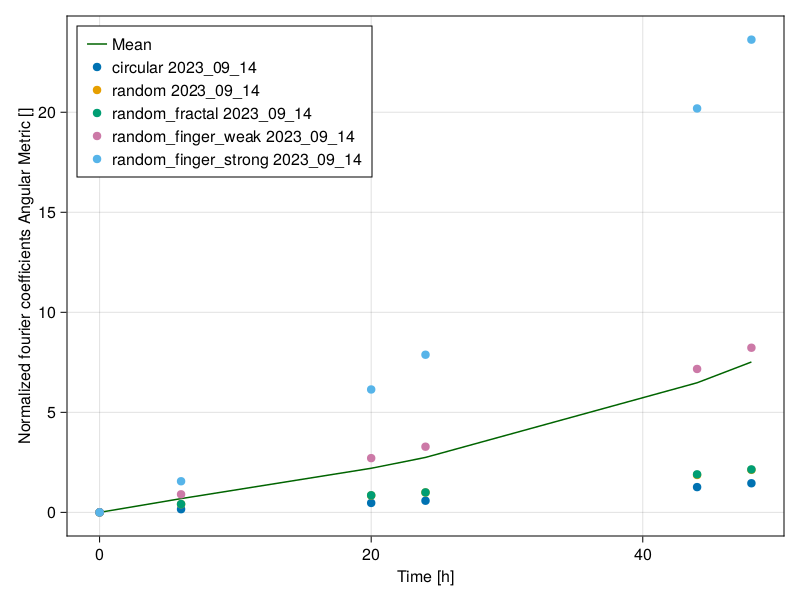

In [33]:
fig4 = lines(abs_fftw.time,abs_fftw.abs_og_n, color = "darkgreen", whiskerwidth = 10, label = "Mean")
for (k, i) in pairs(groupby(abs_fftw_single,:data_set))
    scatter!(fig4.axis, i.time, i.abs_og_n, label = String(k.data_set))
end
fig4.axis.xlabel ="Time [h]"
fig4.axis.ylabel ="Normalized fourier coefficients Angular Metric []"

axislegend(fig4.axis, position = :lt)

save(joinpath(path," Normalized fourier coefficients Angular Metric Angular Metric_OG.png"),fig4)
fig4


In [34]:
fft_data_r = @chain data_full begin 
    @transform(:fourier_conv = (fft.(:metric_cov)), :fourier_OG = (fft.(:metric_OG)))
    @transform(:abs_cov = [abs.(x[2:360÷2]) for x in :fourier_conv], :abs_OG = [abs.(x[2:360÷2]) for x in :fourier_OG])
    @transform(:abs_cov_n = :abs_cov./:OG_size, :abs_OG_n = :abs_OG ./ :OG_size)

end
first(fft_data_r)

Row,data_set,colony,time,metric_cov,metric_OG,pair_OG,pair_cov,OG_size,fourier_conv,fourier_OG,abs_cov,abs_OG,abs_cov_n,abs_OG_n
,String,String,Int64,Array…,Array…,Array…,Array…,Int64,Array…,Array…,Array…,Array…,Array…,Array…
1,14_06_23_stacked_full_res,Kolonie-1 seg.tif,0,"[0, 36, 51, 46, 47, 47, 48, 48, 46, 51 … 44, 51, 46, 47, 48, 47, 47, 46, 49, 109]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0 … 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[3117, 5369, 5589, 5610, 5596, 5626, 5537, 5642, 5434, 5611 … 5505, 5562, 5652, 5513, 5652, 5562, 5505, 5716, 5383, 2871]","[5338, 5545, 5520, 5777, 5550, 5610, 5518, 5535, 5527, 5602 … 5616, 5696, 5670, 5574, 5547, 5678, 5615, 5610, 5518, 5621]",16675,"ComplexF64[16675.0+0.0im, 99.5793-13.2053im, 43.3882+49.9286im, 135.108-24.3583im, 1.62511-53.0144im, -44.7534-30.9749im, -55.9687+52.126im, 72.7058+15.0427im, -17.9243-0.0067771im, 17.2809+22.9634im … -5.30812-45.8975im, 17.2809-22.9634im, -17.9243+0.0067771im, 72.7058-15.0427im, -55.9687-52.126im, -44.7534+30.9749im, 1.62511+53.0144im, 135.108+24.3583im, 43.3882-49.9286im, 99.5793+13.2053im]","ComplexF64[0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im … 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im]","[100.451, 66.1468, 137.287, 53.0393, 54.4271, 76.4828, 74.2457, 17.9243, 28.7393, 46.2034 … 140.776, 129.545, 74.5963, 145.949, 152.095, 135.649, 137.425, 149.264, 152.104, 142.672]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0 … 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.00602405, 0.00396682, 0.00823308, 0.00318077, 0.003264, 0.00458667, 0.00445252, 0.00107492, 0.0017235, 0.00277082 … 0.00844231, 0.0077688, 0.00447354, 0.00875258, 0.00912113, 0.00813486, 0.0082414, 0.00895137, 0.00912167, 0.00855601]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0 … 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"


In [35]:
abs_fftw_r = @chain fft_data_r begin 
    groupby(:time)
    @combine(:abs_og = mean(sum.(:abs_OG)) , :abs_cov = mean(sum.(:abs_cov)),:abs_og_n = mean(sum.(:abs_OG_n)),:abs_cov_n = mean(sum.(:abs_cov_n)),:abs_og_n_std = std(sum.(:abs_OG_n)) )
end

Row,time,abs_og,abs_cov,abs_og_n,abs_cov_n,abs_og_n_std
,Int64,Float64,Float64,Float64,Float64,Float64
1,0,0.0,21127.7,0.0,1.0815,0.0
2,3,6178.51,18460.8,0.232763,0.630841,0.217877
3,4,5204.01,12806.5,0.342147,0.856198,0.0828637
4,19,59156.7,61133.3,2.14392,2.19139,1.55922
5,20,44972.9,44927.8,2.95133,2.93397,0.981017
6,24,84390.7,83534.8,4.18188,4.13021,1.72475
7,43,3.18116e5,3.16579e5,11.3236,11.2641,3.72263
8,44,2.61143e5,2.59082e5,17.0809,16.9521,3.08389
9,48,3.32596e5,3.30848e5,16.1378,16.0472,4.90487


In [36]:
labels_arti = ["Simulated Random Growth", "Simulated Weak Finger Growth", "Simulated Strong Finger Growth"]
#without circular and fractal 
abs_fftw_single_reduced = @rsubset(abs_fftw_single, :data_set in ["random_finger_strong 2023_09_14",
        "random_finger_weak 2023_09_14","random 2023_09_14"])
first(abs_fftw_single_reduced)

Row,time,data_set,abs_og,abs_cov,abs_og_n,abs_cov_n
,Int64,String,Float64,Float64,Float64,Float64
1,0,random 2023_09_14,0.0,19140.5,0.0,0.929648


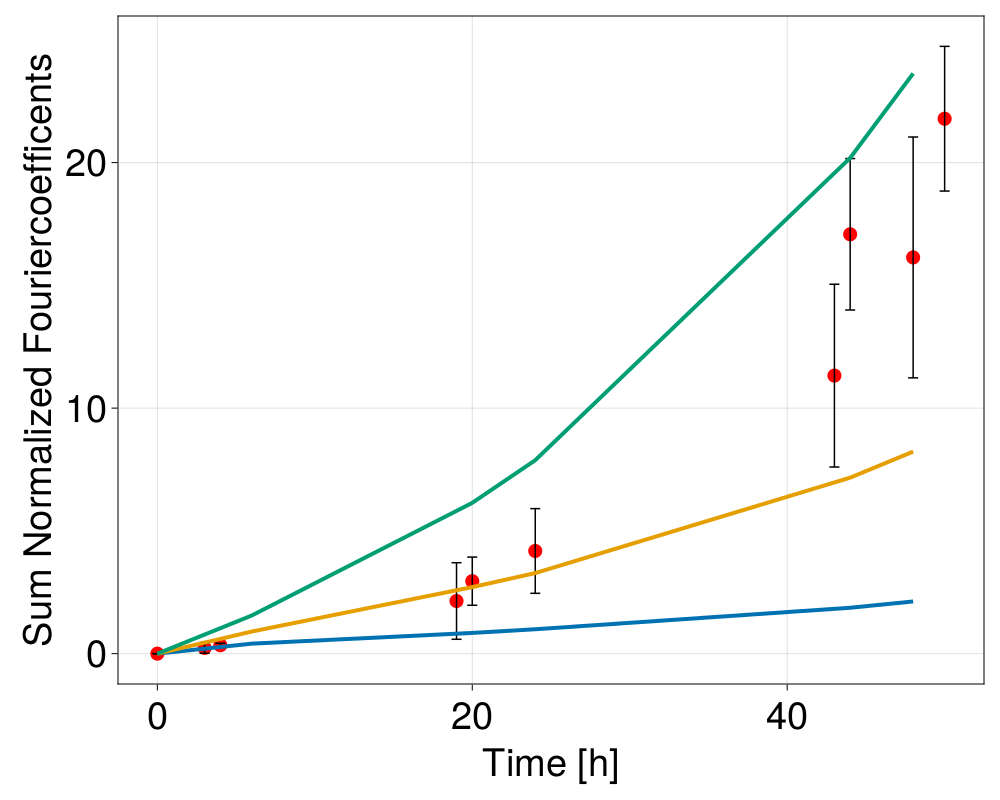

In [65]:
fig5 = Figure(fontsize = 38,resolution = (1000,800))
ax = CairoMakie.Axis(fig5[1,1])
scatter!(ax,abs_fftw_r.time, abs_fftw_r.abs_og_n , label = "Real colonies", markersize = 20, color = "red") 
errorbars!(ax, abs_fftw_r.time, abs_fftw_r.abs_og_n , abs_fftw_r.abs_og_n_std, whiskerwidth = 10)
ax.xlabel ="Time [h]"
ax.ylabel ="Sum Normalized Fouriercoefficents"
j = 1
for (k, i) in pairs(groupby(abs_fftw_single_reduced,:data_set))
    lines!(ax, i.time, i.abs_og_n, label = labels_arti[j],linewidth =4)
    #errorbars!(ax, i.time, i.pair_og,i.pair_og_stdd )
    j += 1
end
#axislegend(ax, position = :lt)
save(joinpath(path,"Comparision_coefficent_fourier_no_unit.png"),fig5)
fig5

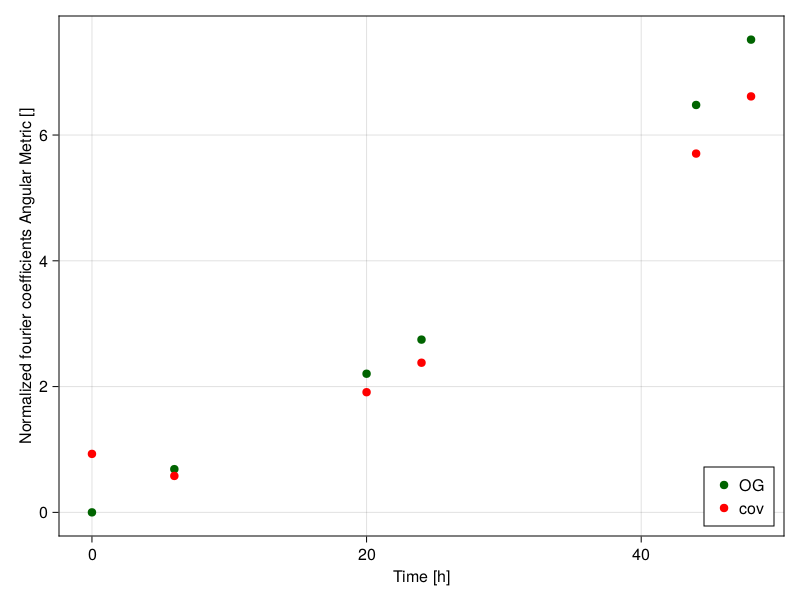

In [38]:
fig4 = scatter(abs_fftw.time,abs_fftw.abs_og_n, color = "darkgreen", whiskerwidth = 10, label = "OG")
scatter!(fig4.axis,abs_fftw.time,abs_fftw.abs_cov_n, color = "red", whiskerwidth = 10, label =  "cov")
#errorbars!(cv_angu.time,cv_angular_max.cv_angu, ,whiskerwidth = 10)
fig4.axis.xlabel ="Time [h]"
fig4.axis.ylabel ="Normalized fourier coefficients Angular Metric []"

axislegend(fig4.axis, position = :rb)
save(joinpath(path,"Average Normalized fourier coefficients Angular Metric Angular Metric.png"),fig4)
fig4


In [39]:
test_spec = fft_data.abs_OG_n[800];

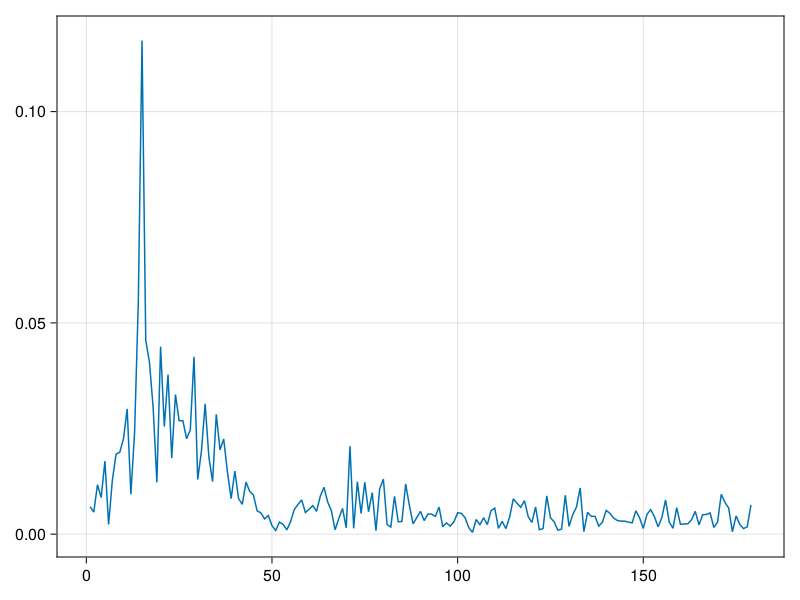

In [40]:
lines(test_spec)

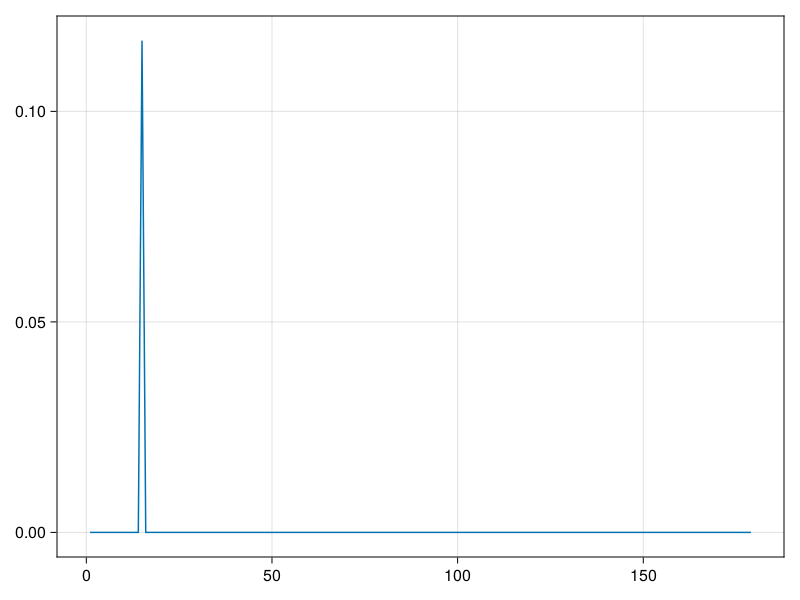

In [41]:
test_spec_fil_b = filter_fourier_beta(test_spec);
lines(test_spec_fil_b)

In [42]:
all_frequ = vcat(filter_fourier_beta2.(fft_data.abs_OG_n)...)

171840-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [43]:
histo_data = vcat(find_freq.(filter_fourier_beta2.(fft_data.abs_OG_n[600:end], b  =0.5))...);

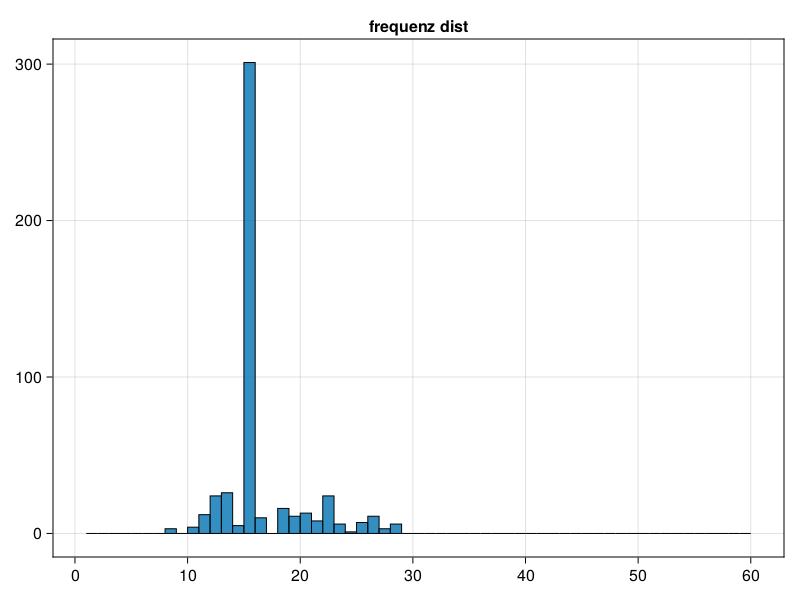

In [44]:
hans = hist(histo_data, bins = 1:60,strokewidth = 1)
hans.axis.title =  "frequenz dist"
hans

### Size increase measure in pixel in circular metric

In [45]:
first(data)

Row,data_set,colony,time,metric_OG,metric_cov,pair_OG,pair_cov,OG_size
,String,String,Int64,Array…,Array…,Array…,Array…,Int64
1,circular 2023_09_14,Colony 1 artifical,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0 … 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 46, 59, 53, 58, 57, 57, 58, 56, 62 … 53, 62, 56, 58, 57, 57, 58, 53, 59, 126]","[5555, 5546, 5447, 5537, 5552, 5563, 5499, 5483, 5464, 5574 … 5552, 5656, 5490, 5499, 5625, 5594, 5572, 5551, 5542, 5373]","[5471, 5497, 5554, 5544, 5645, 5485, 5664, 5577, 5650, 5612 … 5541, 5650, 5582, 5465, 5465, 5549, 5611, 5441, 5611, 5505]",20589


In [46]:
size_data = @chain data begin 
    groupby([:time])
    @combine(:abs_size = mean(sum.(:metric_cov)) ,:abs_size_normalized = mean(sum.(:metric_OG))./mean(:OG_size) ,:OG_size = mean(:OG_size) )
end

Row,time,abs_size,abs_size_normalized,OG_size
,Int64,Float64,Float64,Float64
1,0,20589.0,0.0,20589.0
2,6,1858.99,0.193479,20589.0
3,20,6337.47,0.799395,20589.0
4,24,8035.41,1.02457,20589.0
5,44,19564.9,2.6351,20589.0
6,48,22634.1,3.08894,20589.0


In [47]:
cor_size = size_data.abs_size_normalized.+1

6-element Vector{Float64}:
 1.0
 1.1934792243430958
 1.7993950046141145
 2.0245725873038998
 3.635102481907815
 4.088942517849337

In [48]:
ex(x,p) =(1+(p[1])).^x
p1 = [0.001]
fit2 = curve_fit(ex,size_data.time ,cor_size , p1)

LsqFit.LsqFitResult{Vector{Float64}, Vector{Float64}, Matrix{Float64}, Vector{Float64}}([0.029773932609948355], [0.0, -0.000998509640892875, -0.001195471417507754, -0.0024594221588283283, 0.0010604677267647133, -8.651963199213242e-7], [0.0; 6.9480145714533945; … ; 155.3653344520713; 190.5944553056881;;], true, Float64[])

In [49]:
y2 = ex(size_data.time,fit2.param)
fit2.param

1-element Vector{Float64}:
 0.029773932609948355

In [50]:
1/fit2.param[1]

33.58642652619796

In [51]:
fit2.resid

6-element Vector{Float64}:
  0.0
 -0.000998509640892875
 -0.001195471417507754
 -0.0024594221588283283
  0.0010604677267647133
 -8.651963199213242e-7

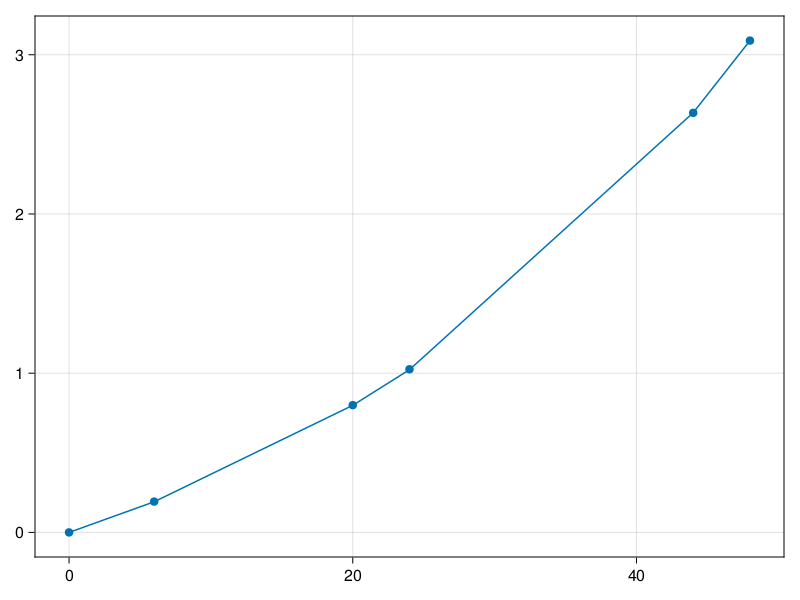

In [52]:
fig10 =scatter(size_data.time, size_data.abs_size_normalized)
lines!(fig10.axis, size_data.time, y2.-1)
fig10

In [53]:
first(data)

Row,data_set,colony,time,metric_OG,metric_cov,pair_OG,pair_cov,OG_size
,String,String,Int64,Array…,Array…,Array…,Array…,Int64
1,circular 2023_09_14,Colony 1 artifical,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0 … 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 46, 59, 53, 58, 57, 57, 58, 56, 62 … 53, 62, 56, 58, 57, 57, 58, 53, 59, 126]","[5555, 5546, 5447, 5537, 5552, 5563, 5499, 5483, 5464, 5574 … 5552, 5656, 5490, 5499, 5625, 5594, 5572, 5551, 5542, 5373]","[5471, 5497, 5554, 5544, 5645, 5485, 5664, 5577, 5650, 5612 … 5541, 5650, 5582, 5465, 5465, 5549, 5611, 5441, 5611, 5505]",20589


In [54]:
size(data)

(960, 8)

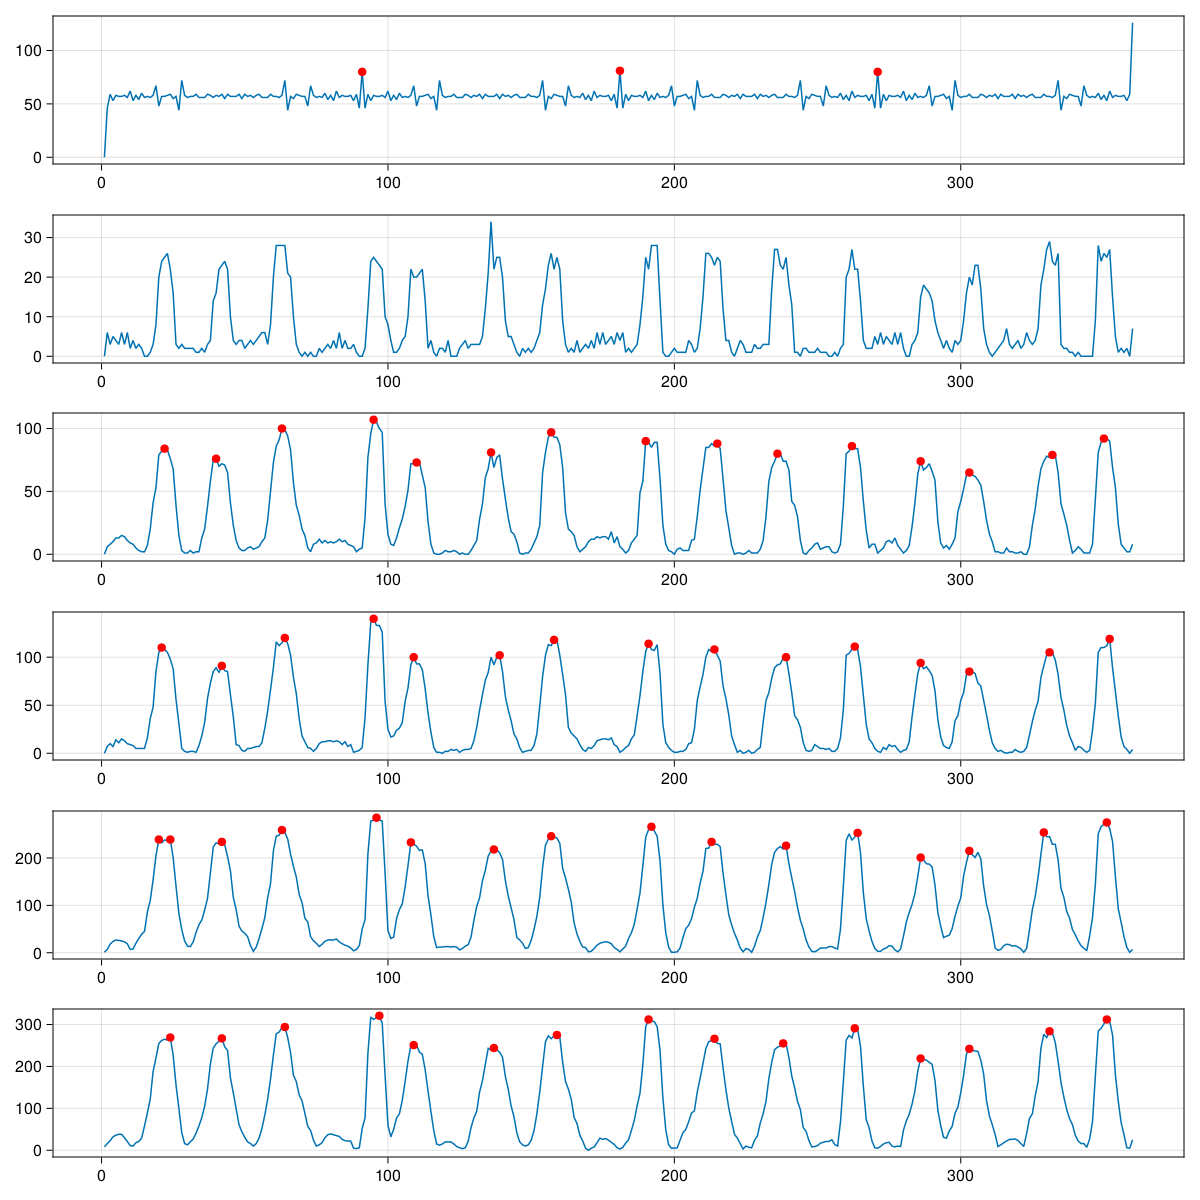

In [55]:
fig6 = Figure(resolution =(1200,1200))
for i in 1:6
    data1 = data.metric_cov[i+642];
    ax = CairoMakie.Axis(fig6[i,1])
    lines!(ax, data1)
    pkindices, properties = findpeaks1d(data1, prominence=0.6*mean(data1), distance = 4, height = 50)
    scatter!(ax, pkindices, data1[[pkindices...]],color = "red" )
end
fig6

In [56]:
peaks_full  = @chain data begin 
    @transform(:nr_peaks_cov = length.([findpeaks1d(i, prominence=0.4*mean(i), distance = 4, height = 40)[1] for i in :metric_cov])  )
end
first(peaks_full)

Row,data_set,colony,time,metric_OG,metric_cov,pair_OG,pair_cov,OG_size,nr_peaks_cov
,String,String,Int64,Array…,Array…,Array…,Array…,Int64,Int64
1,circular 2023_09_14,Colony 1 artifical,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0 … 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 46, 59, 53, 58, 57, 57, 58, 56, 62 … 53, 62, 56, 58, 57, 57, 58, 53, 59, 126]","[5555, 5546, 5447, 5537, 5552, 5563, 5499, 5483, 5464, 5574 … 5552, 5656, 5490, 5499, 5625, 5594, 5572, 5551, 5542, 5373]","[5471, 5497, 5554, 5544, 5645, 5485, 5664, 5577, 5650, 5612 … 5541, 5650, 5582, 5465, 5465, 5549, 5611, 5441, 5611, 5505]",20589,12


In [57]:
peaks_over_time = @chain peaks_full begin
    groupby(:time)
    @combine(:peaks_mean = mean(:nr_peaks_cov), :peaks_stdd =std(:nr_peaks_cov) )
end


Row,time,peaks_mean,peaks_stdd
,Int64,Float64,Float64
1,0,12.0,0.0
2,6,1.68125,3.3988
3,20,5.98125,7.35401
4,24,6.025,7.40894
5,44,6.1625,7.20926
6,48,6.325,7.0582


In [58]:
peaks_over_time_all = @chain peaks_full begin
    groupby([:time,:data_set])
    @combine(:peaks_mean = mean(:nr_peaks_cov), :peaks_stdd =std(:nr_peaks_cov) )
end

Row,time,data_set,peaks_mean,peaks_stdd
,Int64,String,Float64,Float64
1,0,circular 2023_09_14,12.0,0.0
2,6,circular 2023_09_14,0.0,0.0
3,20,circular 2023_09_14,0.0,0.0
4,24,circular 2023_09_14,0.0,0.0
5,44,circular 2023_09_14,0.0,0.0
6,48,circular 2023_09_14,0.0,0.0
7,0,random 2023_09_14,12.0,0.0
8,6,random 2023_09_14,0.0,0.0
9,20,random 2023_09_14,0.0,0.0


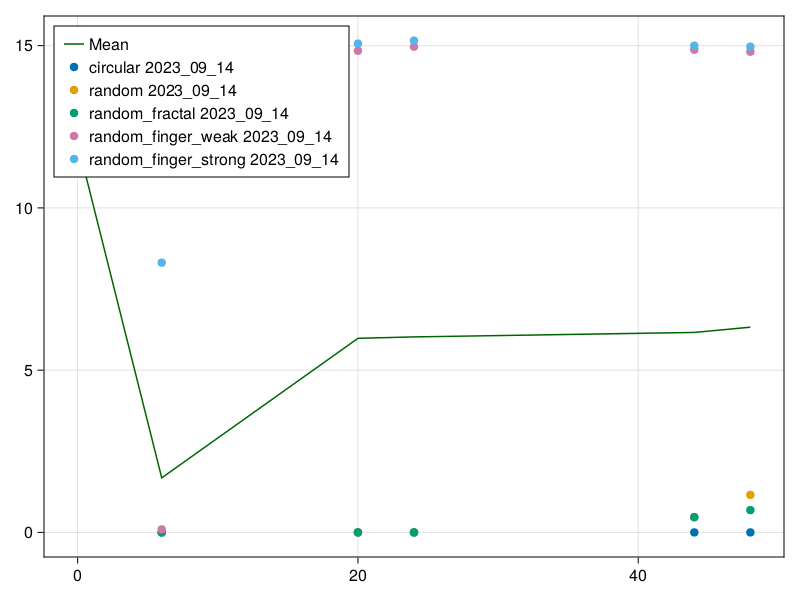

In [59]:
fig7 = lines(peaks_over_time.time,peaks_over_time.peaks_mean, color = "darkgreen", whiskerwidth = 10, label = "Mean")

for (k, i) in pairs(groupby(peaks_over_time_all,:data_set))
    scatter!(fig7.axis, i.time, i.peaks_mean, label = String(k.data_set))
end
axislegend(fig7.axis, position = :lt)
fig7


In [60]:
fIndex_fil = @chain df_f begin 
    @subset(:data_set .== "Daten vom 10-04-23 stacked")
    groupby(:time)
    @combine(:data_stet = :data_set[1],:fil_OG = mean(sum.(:abs_OG)), :fil_cov = mean(sum.(:abs_cov)))
end

LoadError: UndefVarError: `df_f` not defined

In [61]:
pair_10 = @chain data begin
    @subset(:data_set .== "Daten vom 10-04-23 stacked")
    groupby(:time)
    @combine(:pair_og = mean((maximum.(:pair_OG).-mean.(:pair_OG))./mean.(:pair_OG)),
        :pair_og_stdd =std((maximum.(:pair_OG).-mean.(:pair_OG))./mean.(:pair_OG)) )
    

end

Row,time,pair_og,pair_og_stdd
,Int64,Float64,Float64


In [62]:
fig = CairoMakie.scatter(pair_10.pair_og)
errorbars!(1:length(pair_10.time),pair_10.pair_og, pair_10.pair_og_stdd,whiskerwidth = 10)
fig

LoadError: `Makie.convert_arguments` for the plot type LineSegments{Tuple{Vector{Any}}} and its conversion trait PointBased() was unsuccessful.

The signature that could not be converted was:
::Vector{Any}

Makie needs to convert all plot input arguments to types that can be consumed by the backends (typically Arrays with Float32 elements).
You can define a method for `Makie.convert_arguments` (a type recipe) for these types or their supertypes to make this set of arguments convertible (See http://docs.makie.org/stable/documentation/recipes/index.html).

Alternatively, you can define `Makie.convert_single_argument` for single arguments which have types that are unknown to Makie but which can be converted to known types and fed back to the conversion pipeline.


In [49]:
data_14 = @subset(data,:data_set .== "14_06_23_stacked_full_res")
first(data_14,3)

Row,data_set,colony,time,metric_OG,metric_cov,pair_OG,pair_cov,OG_size
,String,String,Int64,Array…,Array…,Array…,Array…,Int64
